In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install shap
!pip install pdpbox

In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.feature_selection import mutual_info_regression
from sklearn.inspection import permutation_importance
from tabulate import tabulate
import shap
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Lasso
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
import calendar
import re


# **1. Data Collection**

In [43]:
# Load data
energymix = pd.read_csv('df_fuel_ckan.csv',index_col="DATETIME", parse_dates=True)
charge = pd.read_csv('national-charge-point-registry.csv')
consumption = pd.read_csv('ET_Consumption.csv')
mgdp = pd.read_csv('mgdp.csv')


<ipython-input-43-954ea6f3aaa2>:3: DtypeWarning: Columns (5,7,10,11,17,18,19,21,24,37,38,42,44,46,47,49,51,54,56,57,58,59,60,61,62,63,64,65,66,67,68,69,79,90,101,104,108,111,112,115,119,122,123,126,130,133,134,137,141,144,148,152,155) have mixed types. Specify dtype option on import or set low_memory=False.
  charge = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/national-charge-point-registry.csv')


In [5]:
energymix.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 265363 entries, 2009-01-01 00:00:00+00:00 to 2024-02-20 09:00:00+00:00
Data columns (total 31 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   GAS               265363 non-null  float64
 1   COAL              265363 non-null  float64
 2   NUCLEAR           265363 non-null  float64
 3   WIND              265363 non-null  float64
 4   HYDRO             265363 non-null  float64
 5   IMPORTS           265363 non-null  float64
 6   BIOMASS           265363 non-null  float64
 7   OTHER             265363 non-null  float64
 8   SOLAR             265363 non-null  float64
 9   STORAGE           265363 non-null  float64
 10  GENERATION        265363 non-null  float64
 11  CARBON_INTENSITY  265363 non-null  float64
 12  LOW_CARBON        265363 non-null  float64
 13  ZERO_CARBON       265363 non-null  float64
 14  RENEWABLE         265363 non-null  float64
 15  FOSSIL            2653

In [6]:
charge.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38591 entries, 0 to 38590
Columns: 158 entries, chargeDeviceID to connector8Validated
dtypes: float64(61), int64(11), object(86)
memory usage: 46.5+ MB


# **2. Data Preprocessing**

Energy generation mix

In [7]:
# Separate columns for YEAR and MONTH from date index
energymix["YEAR"] = energymix.index.year
energymix["MONTH"] = energymix.index.month

In [8]:
# From energymix remove columns 'LOW_CARBON',	'ZERO_CARBON',	'RENEWABLE',	'FOSSIL' and columns ending with _perc because information repeatation.
perc_cols = [col for col in energymix.columns if (col.endswith("_perc") or col in ['LOW_CARBON',	'ZERO_CARBON',	'RENEWABLE',	'FOSSIL'])]
energymix = energymix.drop(perc_cols, axis=1)

energymix.head()


GAS     COAL  NUCLEAR   WIND  HYDRO  IMPORTS  \
DATETIME                                                                     
2009-01-01 00:00:00+00:00  8359.0  15036.0   7098.0  275.0  246.0   2512.0   
2009-01-01 00:30:00+00:00  8482.0  15094.0   7087.0  254.0  245.0   2492.0   
2009-01-01 01:00:00+00:00  8444.0  15082.0   7073.0  229.0  246.0   2458.0   
2009-01-01 01:30:00+00:00  8295.0  15019.0   7064.0  212.0  246.0   2425.0   
2009-01-01 02:00:00+00:00  8265.0  14982.0   7051.0  195.0  246.0   2356.0   

                           BIOMASS  OTHER  SOLAR  STORAGE  GENERATION  \
DATETIME                                                                
2009-01-01 00:00:00+00:00      0.0    0.0    0.0      0.0     33525.0   
2009-01-01 00:30:00+00:00      0.0    0.0    0.0      0.0     33654.0   
2009-01-01 01:00:00+00:00      0.0    0.0    0.0      0.0     33533.0   
2009-01-01 01:30:00+00:00      0.0    0.0    0.0      0.0     33261.0   
2009-01-01 02:00:00+00:00      0.0    0.0    0.0      0.0     33095.0   

                           CARBON_INTENSITY  YEAR  MONTH  
DATETIME                                                  
2009-01-01 00:00:00+00:00             525.0  2009      1  
2009-01-01 00:30:00+00:00             526.0  2009      1  
2009-01-01 01:00:00+00:00             527.0  2009      1  
2009-01-01 01:30:00+00:00             528.0  2009      1  
2009-01-01 02:00:00+00:00             529.0  2009      1

In [9]:
# Converting from KW to GW
cols_to_convert = ['GAS', 'COAL', 'NUCLEAR', 'WIND', 'HYDRO', 'IMPORTS', 'BIOMASS', 'OTHER', 'SOLAR', 'STORAGE', 'GENERATION']

for col in cols_to_convert:
  energymix[col] = energymix[col] / 1000000

energymix.head()

GAS      COAL   NUCLEAR      WIND     HYDRO  \
DATETIME                                                                      
2009-01-01 00:00:00+00:00  0.008359  0.015036  0.007098  0.000275  0.000246   
2009-01-01 00:30:00+00:00  0.008482  0.015094  0.007087  0.000254  0.000245   
2009-01-01 01:00:00+00:00  0.008444  0.015082  0.007073  0.000229  0.000246   
2009-01-01 01:30:00+00:00  0.008295  0.015019  0.007064  0.000212  0.000246   
2009-01-01 02:00:00+00:00  0.008265  0.014982  0.007051  0.000195  0.000246   

                            IMPORTS  BIOMASS  OTHER  SOLAR  STORAGE  \
DATETIME                                                              
2009-01-01 00:00:00+00:00  0.002512      0.0    0.0    0.0      0.0   
2009-01-01 00:30:00+00:00  0.002492      0.0    0.0    0.0      0.0   
2009-01-01 01:00:00+00:00  0.002458      0.0    0.0    0.0      0.0   
2009-01-01 01:30:00+00:00  0.002425      0.0    0.0    0.0      0.0   
2009-01-01 02:00:00+00:00  0.002356      0.0    0.0    0.0      0.0   

                           GENERATION  CARBON_INTENSITY  YEAR  MONTH  
DATETIME                                                              
2009-01-01 00:00:00+00:00    0.033525             525.0  2009      1  
2009-01-01 00:30:00+00:00    0.033654             526.0  2009      1  
2009-01-01 01:00:00+00:00    0.033533             527.0  2009      1  
2009-01-01 01:30:00+00:00    0.033261             528.0  2009      1  
2009-01-01 02:00:00+00:00    0.033095             529.0  2009      1

In [10]:
# Form data group rows by YEAR and MONTH, take sum
energymix_grouped_data = energymix.groupby(['YEAR', 'MONTH'])[['GAS', 'COAL', 'NUCLEAR', 'WIND', 'HYDRO', 'IMPORTS', 'BIOMASS',
       'OTHER', 'SOLAR', 'STORAGE', 'GENERATION', 'CARBON_INTENSITY']].sum()
energymix_grouped_data['CARBON_INTENSITY'] = energymix.groupby(['YEAR', 'MONTH'])['CARBON_INTENSITY'].mean()

energymix_grouped_data.head()

GAS       COAL    NUCLEAR      WIND     HYDRO   IMPORTS  \
YEAR MONTH                                                                  
2009 1      22.765395  30.849395   8.623216  0.862485  0.811042  0.882445   
     2      19.651944  25.219773  10.836805  0.564927  0.542855  0.832595   
     3      22.894299  19.939093  12.684563  0.955628  0.861945  1.026610   
     4      22.166407  13.295858  12.074650  0.634047  0.558552  1.897980   
     5      23.179257  12.618720  10.158450  0.812643  0.459668  2.600156   

            BIOMASS  OTHER  SOLAR   STORAGE  GENERATION  CARBON_INTENSITY  
YEAR MONTH                                                                 
2009 1          0.0    0.0    0.0  0.682214   65.476180        578.415323  
     2          0.0    0.0    0.0  0.675286   58.324152        534.937500  
     3          0.0    0.0    0.0  0.626558   58.988688        464.458333  
     4          0.0    0.0    0.0  0.439888   51.067371        408.876389  
     5          0.0    0.0    0.0  0.573244   50.402105        409.799059

In [11]:
energymix_grouped_data.tail()

GAS      COAL   NUCLEAR       WIND     HYDRO   IMPORTS  \
YEAR MONTH                                                                 
2023 10     12.338165  0.726228  6.371257  15.316046  0.882318  5.028648   
     11     15.201233  1.158699  5.672885  14.990730  0.676988  5.982496   
     12     13.114381  0.605764  7.237704  20.745938  0.779497  4.316275   
2024 1      19.301838  0.950295  4.896721  18.093460  0.845422  5.038769   
     2       7.935701  0.377949  3.493918  11.405453  0.660269  4.141251   

             BIOMASS     OTHER     SOLAR   STORAGE  GENERATION  \
YEAR MONTH                                                       
2023 10     2.778044  0.499239  1.601574  0.323464   45.864990   
     11     3.403159  0.500361  0.938528  0.334804   48.859896   
     12     2.993228  0.558535  0.414101  0.463434   51.228871   
2024 1      3.349729  0.502784  0.847617  0.440982   54.267621   
     2      2.081921  0.317649  0.586557  0.252508   31.253160   

            CARBON_INTENSITY  
YEAR MONTH                    
2023 10           134.239919  
     11           159.181250  
     12           121.414651  
2024 1            166.358199  
     2            128.294307

In [12]:
#Remove data from year 2024 in above
energymix_grouped_data = energymix_grouped_data[energymix_grouped_data.index.get_level_values('YEAR') != 2024]
energymix_grouped_data.tail()

GAS      COAL   NUCLEAR       WIND     HYDRO   IMPORTS  \
YEAR MONTH                                                                 
2023 8      14.645179  0.202782  6.123774   9.769393  0.419869  5.143499   
     9      14.083499  0.614457  7.414461  10.564012  0.480712  4.519033   
     10     12.338165  0.726228  6.371257  15.316046  0.882318  5.028648   
     11     15.201233  1.158699  5.672885  14.990730  0.676988  5.982496   
     12     13.114381  0.605764  7.237704  20.745938  0.779497  4.316275   

             BIOMASS     OTHER     SOLAR   STORAGE  GENERATION  \
YEAR MONTH                                                       
2023 8      1.719129  0.420693  3.114650  0.117182   41.676133   
     9      1.810322  0.471008  2.506885  0.171118   42.635504   
     10     2.778044  0.499239  1.601574  0.323464   45.864990   
     11     3.403159  0.500361  0.938528  0.334804   48.859896   
     12     2.993228  0.558535  0.414101  0.463434   51.228871   

            CARBON_INTENSITY  
YEAR MONTH                    
2023 8            156.167339  
     9            155.693056  
     10           134.239919  
     11           159.181250  
     12           121.414651

Chrging Points

In [13]:
# How many unique values in charge for chargeDeviceID
unique_charge_devices = charge['chargeDeviceID'].nunique()
print(f"Number of unique charge devices: {unique_charge_devices}")


Number of unique charge devices: 38591


In [14]:
# Drop unneccessary columns
columns_to_keep = ['chargeDeviceID', 'reference', 'name', 'latitude', 'longitude', 'town', 'county', 'postcode', 'dateCreated', 'dateUpdated']
columns_to_drop = set(charge.columns) - set(columns_to_keep)
charge = charge.drop(columns=columns_to_drop)

In [15]:
# Convert columns to timestamps
charge['dateCreated'] = pd.to_datetime(charge['dateCreated'], errors='coerce')
charge['dateUpdated'] = pd.to_datetime(charge['dateUpdated'], errors='coerce')
# for 0000-00-00 00:00:00 put NaT (otherwise error)

# Replace NaT values in 'dateCreated' with corresponding dates from 'dateUpdated'
charge['dateCreated'].fillna(charge['dateUpdated'], inplace=True)

# Drop dateUpdated, as not needed
charge.drop(columns='dateUpdated', inplace=True)

In [16]:
# Extract year and month from datetime
charge['YEAR'] = charge['dateCreated'].dt.year
charge['MONTH'] = charge['dateCreated'].dt.month


In [17]:
# Sort the by year and month

charge.sort_values(by=['YEAR', 'MONTH'], inplace=True)


In [18]:
charge.head()


chargeDeviceID reference  \
1902  9c8661befae6dbcd08304dbf4dcaf0db      SC22   
1903  52b738b303d90a884137546353e09ebb      SC23   
1904  b58ac8403eb9cf17fae1dcd16df71fde      SC33   
1905  fd8c07a31f8a85910ad8476f5f7efb27      SC03   
1906  f507783927f2ec2737ba40afbd17efb5      SC19   

                                          name   latitude  longitude     town  \
1902    Little Victoria St Car Park - Socket 2  54.592703  -5.933430  Belfast   
1903  Little Donegall Street, Belfast (Socket   54.604646  -5.931866  Belfast   
1904         Cromac Street Car Park (Socket 2)  54.594109  -5.924292  Belfast   
1905  Hope Street Car Park, Belfast (Socket 2)  54.593365  -5.935574  Belfast   
1906       Adelaide Street, Belfast (Socket 2)  54.594342  -5.928256  Belfast   

             county  postcode         dateCreated  YEAR  MONTH  
1902  County Antrim   BT2 7JQ 2012-04-12 10:17:49  2012      4  
1903  County Antrim   BT1 2JD 2012-04-12 14:00:01  2012      4  
1904  County Antrim   BT2 8JN 2012-04-12 14:10:27  2012      4  
1905  County Antrim  BT12 5ED 2012-04-12 14:16:09  2012      4  
1906  County Antrim   BT2 8GB 2012-04-12 14:17:57  2012      4

In [19]:
charge.tail()

chargeDeviceID reference                    name  \
38579  9bcc55f2146b211f2cc87e59ec6b39c2   BAR 019         10-12 HALE LANE   
38580  600c17f217ca1fc5d44e062c809cbc72   BAR 020      60-62 THE BROADWAY   
38581  73e7eccfcb0d423b59f70c796cf5aa9f   BAR 073  14-15 MONKVILLE PARADE   
38582  84b751775bf45610fe48701046ff7ad1   BAR 033               BELL LANE   
38583  ff7b29042de2ddca8a4cd0554276013d   BAR 128             BELL LANE 2   

        latitude  longitude    town  county  postcode         dateCreated  \
38579  51.614205  -0.251155  Barnet  London   NW7 3NX 2024-02-02 15:16:06   
38580  51.614940  -0.246206  London  Barnet   NW7 3TE 2024-02-02 16:00:41   
38581  51.588224  -0.199926  Barnet  London  NW11 0AL 2024-02-12 11:39:03   
38582  51.586295  -0.220008  Barnet  London   NW4 2AD 2024-02-12 11:51:23   
38583  51.586239  -0.219886  London  Barnet   NW4 2DT 2024-02-12 11:54:44   

       YEAR  MONTH  
38579  2024      2  
38580  2024      2  
38581  2024      2  
38582  2024      2  
38583  2024      2

In [20]:
#Remove data from year 2024 from charge

charge = charge[charge['YEAR'] != 2024]
charge.tail()


chargeDeviceID   reference  \
38586  0b679813d957cebc8a382fdfa5ecf261  23BZ1125BX   
38587  c3c38bb0b4ba731e8843b8229f8b2457   23BZ1127B   
38588  9cc78a3d1c3e408768736970841adf9c   23BZ1122B   
38589  4e9a11c06042c3ac9791359f821402a6   23BZ1277B   
38590  0cb94725207d36a9cde92f8b25ed8614   23BZ1276B   

                                     name   latitude  longitude        town  \
38586               Teesbay Retail Park 3  54.665278  -1.208947  Hartlepool   
38587  McDonald's Lowestoft Leisure Way 1  52.501715   1.735770   Lowestoft   
38588  McDonald's Lowestoft Leisure Way 2  52.501715   1.735770   Lowestoft   
38589  McDonald's Lowestoft Leisure Way 3  52.501715   1.735770   Lowestoft   
38590  McDonald's Lowestoft Leisure Way 4  52.501715   1.735770   Lowestoft   

              county  postcode         dateCreated  YEAR  MONTH  
38586  County Durham  TS25 1XJ 2023-12-11 17:11:48  2023     12  
38587        Suffolk  NR32 4TZ 2023-12-20 10:41:26  2023     12  
38588        Suffolk  NR32 4TZ 2023-12-20 10:43:45  2023     12  
38589        Suffolk  NR32 4TZ 2023-12-20 10:45:29  2023     12  
38590        Suffolk  NR32 4TZ 2023-12-20 10:47:07  2023     12

In [21]:
# Get the cumulative count for charge stations, group by year and month
charge_cumulative = charge.groupby(['YEAR', 'MONTH'])['chargeDeviceID'].count().cumsum()
charge_cumulative.head()


YEAR  MONTH
2012  4         40
      6         97
      11        98
2013  3        184
      4        219
Name: chargeDeviceID, dtype: int64

In [22]:
charge_cumulative.tail()

YEAR  MONTH
2023  8        26196
      9        27423
      10       29853
      11       30829
      12       35317
Name: chargeDeviceID, dtype: int64

Energy consumption

In [23]:
consumption.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 350 entries, 0 to 349
Data columns (total 16 columns):
 #   Column                                                                           Non-Null Count  Dtype  
---  ------                                                                           --------------  -----  
 0   Month                                                                            350 non-null    object 
 1   Electricity available from the public distribution system                        350 non-null    float64
 2   Losses and statistical differences from the public distribution system
[note 4]  350 non-null    float64
 3   Sales in England and Wales                                                       350 non-null    object 
 4   Sales in Scotland                                                                350 non-null    object 
 5   Sales in Northern Ireland                                                        350 non-null    object 
 6   Total sale

In [24]:
consumption.head()

Month  Electricity available from the public distribution system  \
0  Jan-95                                              28.50           
1  Feb-95                                              27.88           
2  Mar-95                                              33.33           
3  Apr-95                                              23.88           
4  May-95                                              22.61           

   Losses and statistical differences from the public distribution system\n[note 4]  \
0                                               2.86                                  
1                                               2.69                                  
2                                               3.21                                  
3                                               2.28                                  
4                                               2.09                                  

  Sales in England and Wales Sales in Scotland Sales in Northern Ireland  \
0                        [x]               [x]                       [x]   
1                        [x]               [x]                       [x]   
2                        [x]               [x]                       [x]   
3                        [x]               [x]                       [x]   
4                        [x]               [x]                       [x]   

   Total sales to consumers\n[note 5]\n[note 6]  Industrial sales\n[note 7]  \
0                                         25.64                        7.76   
1                                         25.19                        7.96   
2                                         30.12                        9.28   
3                                         21.60                        7.05   
4                                         20.52                        7.56   

   Domestic sales  Other sales \n[note 8]  \
0           10.03                    7.85   
1            9.66                    7.56   
2           12.22                    8.62   
3            7.81                    6.75   
4            6.54                    6.42   

   Electricity available from other generators \n[note 9]  \
0                                               1.35        
1                                               1.33        
2                                               1.58        
3                                               1.27        
4                                               1.21        

   Losses and statistical differences from other generators  \
0                                               0.01          
1                                               0.01          
2                                               0.01          
3                                               0.03          
4                                               0.03          

   Electricity consumption by other generators \n[note 10]  \
0                                               1.34         
1                                               1.32         
2                                               1.57         
3                                               1.25         
4                                               1.18         

   Total electricity available  Total losses and statistical differences  \
0                        29.85                                      2.87   
1                        29.20                                      2.70   
2                        34.91                                      3.22   
3                        25.16                                      2.31   
4                        23.82                                      2.12   

   Total electricity consumption  
0                          26.98  
1                          26.50  
2                          31.69  
3                          22.85  
4                          21.70

In [25]:
# Removing data from years 2024
consumption = consumption[~((consumption['Month'].astype(str).str.contains('24')))]


# Define a function to extract the year and check if it falls within the specified range
def is_year_to_remove(entry):
    year_match = re.search(r'(\d{2})$', entry)
    if year_match:
        # Extract the last two digits and convert to an integer
        year = int(year_match.group(1))
        # Adjust for years in the '90s and '00s
        if year >= 95:
            year += 1900
        else:  # For '00' to '24'
            year += 2000
        # Check if the year is within the range 1995-2008 or is 2024
        return 1995 <= year <= 2008
    return False

# Filter the dataframe based on the year
consumption = consumption[~consumption['Month'].astype(str).apply(is_year_to_remove)]

# Removing repeteative information
remove = ['Electricity available from other generators \n[note 9]','Losses and statistical differences from other generators','Electricity consumption by other generators \n[note 10]']
consumption = consumption.drop(columns=remove)


In [26]:
consumption.head()

Month  Electricity available from the public distribution system  \
168  Jan-09                                              34.07           
169  Feb-09                                              30.56           
170  Mar-09                                              30.90           
171  Apr-09                                              26.81           
172  May-09                                              26.44           

     Losses and statistical differences from the public distribution system\n[note 4]  \
168                                               3.03                                  
169                                               2.74                                  
170                                               2.60                                  
171                                               3.48                                  
172                                               1.92                                  

    Sales in England and Wales Sales in Scotland Sales in Northern Ireland  \
168                       27.5              2.75                       0.8   
169                      24.59              2.45                      0.78   
170                      24.89              2.58                      0.83   
171                      20.45              2.21                      0.67   
172                      21.56              2.29                      0.68   

     Total sales to consumers\n[note 5]\n[note 6]  Industrial sales\n[note 7]  \
168                                         31.04                        8.28   
169                                         27.83                        7.52   
170                                         28.30                        8.17   
171                                         23.33                        7.21   
172                                         24.52                        7.45   

     Domestic sales  Other sales \n[note 8]  Total electricity available  \
168           13.31                    9.45                        35.69   
169           11.77                    8.54                        32.01   
170           11.30                    8.82                        32.35   
171            8.40                    7.71                        28.20   
172            8.77                    8.30                        27.79   

     Total losses and statistical differences  Total electricity consumption  
168                                      3.04                          32.65  
169                                      2.75                          29.26  
170                                      2.61                          29.75  
171                                      3.49                          24.71  
172                                      1.93                          25.86

In [27]:
consumption.tail()

Month  Electricity available from the public distribution system  \
343  Aug-23                                              20.50           
344  Sep-23                                              21.24           
345  Oct-23                                              22.81           
346  Nov-23                                              25.26           
347  Dec-23                                              25.78           

     Losses and statistical differences from the public distribution system\n[note 4]  \
343                                               1.99                                  
344                                               2.22                                  
345                                               2.57                                  
346                                               3.17                                  
347                                               2.06                                  

    Sales in England and Wales Sales in Scotland Sales in Northern Ireland  \
343                      16.52              1.52                      0.48   
344                      16.89              1.61                      0.52   
345                      17.95              1.76                      0.54   
346                      19.55              1.94                       0.6   
347                      21.05              2.07                      0.59   

     Total sales to consumers\n[note 5]\n[note 6]  Industrial sales\n[note 7]  \
343                                         18.52                        6.05   
344                                         19.02                        6.00   
345                                         20.24                        6.11   
346                                         22.09                        6.08   
347                                         23.72                        6.34   

     Domestic sales  Other sales \n[note 8]  Total electricity available  \
343            5.97                    6.50                        22.09   
344            6.19                    6.83                        22.95   
345            7.32                    6.81                        24.65   
346            8.51                    7.50                        27.18   
347            9.31                    8.06                        27.76   

     Total losses and statistical differences  Total electricity consumption  
343                                      2.21                          19.89  
344                                      2.46                          20.49  
345                                      2.82                          21.82  
346                                      3.43                          23.75  
347                                      2.34                          25.42

In [28]:
# Helper function to convert abbreviated month to full month name
def convert_month(abbr):
    # Map from abbreviated month name to full month name
    month_dict = {month[:3]: name for month, name in zip(calendar.month_abbr[1:], calendar.month_name[1:])}
    return month_dict[abbr.capitalize()]

# Split and convert the 'Month' column
consumption['MONTH'] = consumption['Month'].apply(lambda x: convert_month(x.split('-')[0]) if isinstance(x, str) else None)
consumption['YEAR'] = consumption['Month'].apply(lambda x: 2000 + int(x.split('-')[1]) if isinstance(x, str) and len(x.split('-')[1]) == 2 else None)

# Create a mapping of month names to numbers
month_to_num = {month: index for index, month in enumerate(calendar.month_name) if month}

# Covert from month name to numeric
consumption['MONTH'] = consumption['MONTH'].map(month_to_num)

# Droping Month coloumn
consumption.drop('Month',axis=1 ,inplace=True)
consumption.head()

Electricity available from the public distribution system  \
168                                              34.07           
169                                              30.56           
170                                              30.90           
171                                              26.81           
172                                              26.44           

     Losses and statistical differences from the public distribution system\n[note 4]  \
168                                               3.03                                  
169                                               2.74                                  
170                                               2.60                                  
171                                               3.48                                  
172                                               1.92                                  

    Sales in England and Wales Sales in Scotland Sales in Northern Ireland  \
168                       27.5              2.75                       0.8   
169                      24.59              2.45                      0.78   
170                      24.89              2.58                      0.83   
171                      20.45              2.21                      0.67   
172                      21.56              2.29                      0.68   

     Total sales to consumers\n[note 5]\n[note 6]  Industrial sales\n[note 7]  \
168                                         31.04                        8.28   
169                                         27.83                        7.52   
170                                         28.30                        8.17   
171                                         23.33                        7.21   
172                                         24.52                        7.45   

     Domestic sales  Other sales \n[note 8]  Total electricity available  \
168           13.31                    9.45                        35.69   
169           11.77                    8.54                        32.01   
170           11.30                    8.82                        32.35   
171            8.40                    7.71                        28.20   
172            8.77                    8.30                        27.79   

     Total losses and statistical differences  Total electricity consumption  \
168                                      3.04                          32.65   
169                                      2.75                          29.26   
170                                      2.61                          29.75   
171                                      3.49                          24.71   
172                                      1.93                          25.86   

     MONTH  YEAR  
168      1  2009  
169      2  2009  
170      3  2009  
171      4  2009  
172      5  2009

GDPs

In [29]:
mgdp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332 entries, 0 to 331
Columns: 208 entries, Title to Activities of housholds as employers;Undiff goods & services (3m on 3m 1 year ago contribution) :CVM SA
dtypes: object(208)
memory usage: 539.6+ KB


In [30]:
mgdp.head(10)

Title Gross Value Added - Monthly (Index 1dp) :CVM SA  \
0             CDID                                            ECY2   
1          PreUnit                                             NaN   
2             Unit                                             NaN   
3     Release Date                                      12-04-2024   
4     Next release                                     10 May 2024   
5  Important Notes                                             NaN   
6         1997 JAN                                            63.3   
7         1997 FEB                                            64.0   
8         1997 MAR                                            64.0   
9         1997 APR                                            64.6   

  Agriculture, Forestry and Fishing (Index 1dp) :CVM SA  \
0                                               ECY3      
1                                                NaN      
2                                                NaN      
3                                         12-04-2024      
4                                        10 May 2024      
5                                                NaN      
6                                               51.9      
7                                               52.6      
8                                               53.3      
9                                               54.6      

  Production Industries - Total (Index 1dp) :CVM SA  \
0                                              ECY4   
1                                               NaN   
2                                               NaN   
3                                        12-04-2024   
4                                       10 May 2024   
5                                               NaN   
6                                              81.8   
7                                              82.1   
8                                              80.9   
9                                              82.9   

  Mining and Quarrying (Index 1dp) :CVM SA Manufacturing (Index 1dp) :CVM SA  \
0                                     ECY5                              ECY6   
1                                      NaN                               NaN   
2                                      NaN                               NaN   
3                               12-04-2024                        12-04-2024   
4                              10 May 2024                       10 May 2024   
5                                      NaN                               NaN   
6                                    405.1                              64.2   
7                                    388.8                              64.9   
8                                    377.6                              64.2   
9                                    377.1                              65.8   

  Electricity, gas, steam and air conditioning supply(Index 1dp) :CVM SA  \
0                                               ECY7                       
1                                                NaN                       
2                                                NaN                       
3                                         12-04-2024                       
4                                        10 May 2024                       
5                                                NaN                       
6                                               85.1                       
7                                               82.8                       
8                                               78.5                       
9                                               83.7                       

  Water supply; Sewerage,waste management & remediation activities (Index 1dp) :CVM SA  \
0                                               ECY8                                     
1                                                NaN                                    

In [31]:
# Getting actual data
mgdp = mgdp.iloc[6:]
mgdp.head(10)


Title Gross Value Added - Monthly (Index 1dp) :CVM SA  \
6   1997 JAN                                            63.3   
7   1997 FEB                                            64.0   
8   1997 MAR                                            64.0   
9   1997 APR                                            64.6   
10  1997 MAY                                            64.1   
11  1997 JUN                                            64.5   
12  1997 JUL                                            64.8   
13  1997 AUG                                            64.9   
14  1997 SEP                                            65.0   
15  1997 OCT                                            65.4   

   Agriculture, Forestry and Fishing (Index 1dp) :CVM SA  \
6                                                51.9      
7                                                52.6      
8                                                53.3      
9                                                54.6      
10                                               55.3      
11                                               55.9      
12                                               56.6      
13                                               57.1      
14                                               57.7      
15                                               58.5      

   Production Industries - Total (Index 1dp) :CVM SA  \
6                                               81.8   
7                                               82.1   
8                                               80.9   
9                                               82.9   
10                                              82.6   
11                                              82.8   
12                                              84.5   
13                                              83.5   
14                                              84.0   
15                                              85.0   

   Mining and Quarrying (Index 1dp) :CVM SA Manufacturing (Index 1dp) :CVM SA  \
6                                     405.1                              64.2   
7                                     388.8                              64.9   
8                                     377.6                              64.2   
9                                     377.1                              65.8   
10                                    371.7                              65.4   
11                                    372.2                              65.6   
12                                    387.0                              66.9   
13                                    380.8                              66.0   
14                                    377.4                              66.6   
15                                    388.2                              67.5   

   Electricity, gas, steam and air conditioning supply(Index 1dp) :CVM SA  \
6                                                85.1                       
7                                                82.8                       
8                                                78.5                       
9                                                83.7                       
10                                               86.2                       
11                                               86.2                       
12                                               88.2                       
13                                               87.0                       
14                                               86.6                       
15                                               87.5                       

   Water supply; Sewerage,waste management & remediation activities (Index 1dp) :CVM SA  \
6                                               116.4                                     
7                                               117.0                                     
8          

In [32]:
# Split and convert the 'Month' column
mgdp['MONTH'] = mgdp['Title'].apply(lambda x: convert_month(x.split(' ')[1]) if isinstance(x, str) else None)
mgdp['YEAR'] = mgdp['Title'].apply(lambda x: int(x.split(' ')[0]) if isinstance(x, str) and len(x.split(' ')[0]) == 4 else None)

# Create a mapping of month names to numbers
month_to_num = {month: index for index, month in enumerate(calendar.month_name) if month}

# Covert from month name to numeric
mgdp['MONTH'] = mgdp['MONTH'].map(month_to_num)

# Droping Month coloumn
mgdp.drop('Title',axis=1 ,inplace=True)
mgdp.head()

Gross Value Added - Monthly (Index 1dp) :CVM SA  \
6                                             63.3   
7                                             64.0   
8                                             64.0   
9                                             64.6   
10                                            64.1   

   Agriculture, Forestry and Fishing (Index 1dp) :CVM SA  \
6                                                51.9      
7                                                52.6      
8                                                53.3      
9                                                54.6      
10                                               55.3      

   Production Industries - Total (Index 1dp) :CVM SA  \
6                                               81.8   
7                                               82.1   
8                                               80.9   
9                                               82.9   
10                                              82.6   

   Mining and Quarrying (Index 1dp) :CVM SA Manufacturing (Index 1dp) :CVM SA  \
6                                     405.1                              64.2   
7                                     388.8                              64.9   
8                                     377.6                              64.2   
9                                     377.1                              65.8   
10                                    371.7                              65.4   

   Electricity, gas, steam and air conditioning supply(Index 1dp) :CVM SA  \
6                                                85.1                       
7                                                82.8                       
8                                                78.5                       
9                                                83.7                       
10                                               86.2                       

   Water supply; Sewerage,waste management & remediation activities (Index 1dp) :CVM SA  \
6                                               116.4                                     
7                                               117.0                                     
8                                               117.8                                     
9                                               120.2                                     
10                                              118.9                                     

   Construction (Index 1dp) :CVM SA  \
6                              88.7   
7                              89.4   
8                              90.3   
9                              92.7   
10                             93.1   

   Service Industries - Total (Index 1dp) :CVM SA  \
6                                            59.0   
7                                            59.7   
8                                            60.0   
9                                            60.2   
10                                           59.6   

   Wholesale & retail trade; Repair of motor vehicles/cycles (Index 1dp) :CVM SA  \
6                                                76.6                              
7                                                77.7                              
8                                                79.7                              
9                                                82.3                              
10                                               77.8                              

    ...  \
6   ...   
7   ...   
8   ...   
9   ...   
10  ...   

   Professional, scientific and technical activities (3m on 3m 1 year ago contribution) :CVM SA  \
6                                                 NaN                                             
7                                                 NaN                                             
8                                                 NaN       

In [33]:
mgdp[['MONTH','YEAR']].head()

MONTH  YEAR
6       1  1997
7       2  1997
8       3  1997
9       4  1997
10      5  1997

In [34]:
mgdp[['MONTH','YEAR']].tail()

MONTH  YEAR
327     10  2023
328     11  2023
329     12  2023
330      1  2024
331      2  2024

In [35]:
#Remove data from year 2024 from charge
mgdp = mgdp[mgdp['YEAR'] != 2024]
mgdp[['MONTH','YEAR']].tail()

MONTH  YEAR
325      8  2023
326      9  2023
327     10  2023
328     11  2023
329     12  2023

Merging all datasets on YEAR and MONTH

In [36]:
merged_data_1 = pd.merge(energymix_grouped_data, charge_cumulative, on=['YEAR', 'MONTH'], how='left')
merged_data_2 = pd.merge(merged_data_1, consumption, on=['YEAR', 'MONTH'], how='left')
merged_data_new = pd.merge(merged_data_2, mgdp, on=['YEAR', 'MONTH'], how='left')

merged_data_new.head()

YEAR  MONTH        GAS       COAL    NUCLEAR      WIND     HYDRO   IMPORTS  \
0  2009      1  22.765395  30.849395   8.623216  0.862485  0.811042  0.882445   
1  2009      2  19.651944  25.219773  10.836805  0.564927  0.542855  0.832595   
2  2009      3  22.894299  19.939093  12.684563  0.955628  0.861945  1.026610   
3  2009      4  22.166407  13.295858  12.074650  0.634047  0.558552  1.897980   
4  2009      5  23.179257  12.618720  10.158450  0.812643  0.459668  2.600156   

   BIOMASS  OTHER  ...  \
0      0.0    0.0  ...   
1      0.0    0.0  ...   
2      0.0    0.0  ...   
3      0.0    0.0  ...   
4      0.0    0.0  ...   

   Financial and insurance activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                              -0.93                               
1                                              -0.80                               
2                                              -0.69                               
3                                              -0.46                               
4                                              -0.54                               

   Real estate activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                               0.20                   
1                                               0.20                   
2                                               0.21                   
3                                               0.22                   
4                                               0.26                   

   Professional, scientific and technical activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                              -0.34                                              
1                                              -0.41                                              
2                                              -0.50                                              
3                                              -0.47                                              
4                                              -0.49                                              

   Administrative and Support Service Activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                              -0.10                                          
1                                              -0.21                                          
2                                              -0.32                                          
3                                              -0.30                                          
4                                              -0.25                                          

   Public admin and defence; Compulsory social security (3m on 3m 1 year ago contribution) :CVM SA  \
0                                               0.09                                                 
1                                               0.07                                                 
2                                               0.07                                                 
3                                               0.08                                                 
4                                               0.13                                                 

   Education (3m on 3m 1 year ago contribution) :CVM SA  \
0                                              -0.12      
1                                              -0.19      
2                                              -0.20      
3                                              -0.18      
4                                              -0.10      

   Human health and social work activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                               0.00                                    
1                                              -0.04                                    
2                   

In [37]:
print(merged_data_new.isnull().sum().sum())

55


In [38]:
# Replace NaN
merged_data_new['chargeDeviceID'].fillna(method='ffill', inplace=True)
merged_data_new['chargeDeviceID'].fillna(0, inplace=True)

# Change the column name of 'chargeDeviceID' to 'chargingStationCount'
merged_data_new.rename(columns={"chargeDeviceID": "chargingStationCount"}, inplace=True)

merged_data_new.head()


YEAR  MONTH        GAS       COAL    NUCLEAR      WIND     HYDRO   IMPORTS  \
0  2009      1  22.765395  30.849395   8.623216  0.862485  0.811042  0.882445   
1  2009      2  19.651944  25.219773  10.836805  0.564927  0.542855  0.832595   
2  2009      3  22.894299  19.939093  12.684563  0.955628  0.861945  1.026610   
3  2009      4  22.166407  13.295858  12.074650  0.634047  0.558552  1.897980   
4  2009      5  23.179257  12.618720  10.158450  0.812643  0.459668  2.600156   

   BIOMASS  OTHER  ...  \
0      0.0    0.0  ...   
1      0.0    0.0  ...   
2      0.0    0.0  ...   
3      0.0    0.0  ...   
4      0.0    0.0  ...   

   Financial and insurance activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                              -0.93                               
1                                              -0.80                               
2                                              -0.69                               
3                                              -0.46                               
4                                              -0.54                               

   Real estate activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                               0.20                   
1                                               0.20                   
2                                               0.21                   
3                                               0.22                   
4                                               0.26                   

   Professional, scientific and technical activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                              -0.34                                              
1                                              -0.41                                              
2                                              -0.50                                              
3                                              -0.47                                              
4                                              -0.49                                              

   Administrative and Support Service Activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                              -0.10                                          
1                                              -0.21                                          
2                                              -0.32                                          
3                                              -0.30                                          
4                                              -0.25                                          

   Public admin and defence; Compulsory social security (3m on 3m 1 year ago contribution) :CVM SA  \
0                                               0.09                                                 
1                                               0.07                                                 
2                                               0.07                                                 
3                                               0.08                                                 
4                                               0.13                                                 

   Education (3m on 3m 1 year ago contribution) :CVM SA  \
0                                              -0.12      
1                                              -0.19      
2                                              -0.20      
3                                              -0.18      
4                                              -0.10      

   Human health and social work activities (3m on 3m 1 year ago contribution) :CVM SA  \
0                                               0.00                                    
1                                              -0.04                                    
2                   

In [39]:
merged_data_new.tail()

YEAR  MONTH        GAS      COAL   NUCLEAR       WIND     HYDRO  \
175  2023      8  14.645179  0.202782  6.123774   9.769393  0.419869   
176  2023      9  14.083499  0.614457  7.414461  10.564012  0.480712   
177  2023     10  12.338165  0.726228  6.371257  15.316046  0.882318   
178  2023     11  15.201233  1.158699  5.672885  14.990730  0.676988   
179  2023     12  13.114381  0.605764  7.237704  20.745938  0.779497   

      IMPORTS   BIOMASS     OTHER  ...  \
175  5.143499  1.719129  0.420693  ...   
176  4.519033  1.810322  0.471008  ...   
177  5.028648  2.778044  0.499239  ...   
178  5.982496  3.403159  0.500361  ...   
179  4.316275  2.993228  0.558535  ...   

     Financial and insurance activities (3m on 3m 1 year ago contribution) :CVM SA  \
175                                              -0.15                               
176                                              -0.11                               
177                                              -0.06                               
178                                              -0.04                               
179                                              -0.07                               

     Real estate activities (3m on 3m 1 year ago contribution) :CVM SA  \
175                                              -0.10                   
176                                              -0.12                   
177                                              -0.14                   
178                                              -0.13                   
179                                              -0.11                   

     Professional, scientific and technical activities (3m on 3m 1 year ago contribution) :CVM SA  \
175                                              -0.04                                              
176                                              -0.05                                              
177                                              -0.15                                              
178                                              -0.19                                              
179                                              -0.20                                              

     Administrative and Support Service Activities (3m on 3m 1 year ago contribution) :CVM SA  \
175                                               0.31                                          
176                                               0.26                                          
177                                               0.24                                          
178                                               0.20                                          
179                                               0.15                                          

     Public admin and defence; Compulsory social security (3m on 3m 1 year ago contribution) :CVM SA  \
175                                               0.06                                                 
176                                               0.04                                                 
177                                               0.04                                                 
178                                               0.05                                                 
179                                               0.07                                                 

     Education (3m on 3m 1 year ago contribution) :CVM SA  \
175                                               0.13      
176                                               0.16      
177                                               0.20      
178                                               0.16      
179                                               0.12      

     Human health and social work activities (3m on 3m 1 year ago contribution) :CVM SA  \
175                                               0.18                              

In [40]:
merged_data_new.describe()

YEAR       MONTH         GAS        COAL     NUCLEAR  \
count   180.000000  180.000000  180.000000  180.000000  180.000000   
mean   2016.000000    6.500000   18.244811    9.172622    9.615042   
std       4.332545    3.461682    4.504412    9.039614    1.870414   
min    2009.000000    1.000000    9.804662    0.000000    4.788030   
25%    2012.000000    3.750000   14.649299    0.839757    8.230199   
50%    2016.000000    6.500000   18.082293    7.203297   10.078946   
75%    2020.000000    9.250000   20.973814   16.793182   11.081337   
max    2023.000000   12.000000   31.005995   30.849395   12.869564   

             WIND       HYDRO     IMPORTS     BIOMASS       OTHER  ...  \
count  180.000000  180.000000  180.000000  180.000000  180.000000  ...   
mean     6.507066    0.576037    3.211821    1.120604    0.678502  ...   
std      4.722161    0.256348    1.475508    1.399682    0.860549  ...   
min      0.319168    0.140297    0.096176    0.000000    0.000000  ...   
25%      2.517203    0.382625    2.089321    0.000000    0.074144  ...   
50%      5.791854    0.550215    3.461394    0.000000    0.298040  ...   
75%      9.718770    0.759992    4.217977    2.573080    1.035447  ...   
max     20.745938    1.252001    7.648070    4.001664    3.070075  ...   

       chargingStationCount  \
count            180.000000   
mean            4835.250000   
std             6995.943931   
min                0.000000   
25%               97.000000   
50%             2297.000000   
75%             5903.000000   
max            35317.000000   

       Electricity available from the public distribution system  \
count                                         180.000000           
mean                                           26.139389           
std                                             3.240242           
min                                            19.770000           
25%                                            23.727500           
50%                                            25.810000           
75%                                            28.422500           
max                                            35.110000           

       Losses and statistical differences from the public distribution system\n[note 4]  \
count                                         180.000000                                  
mean                                            2.245167                                  
std                                             0.612905                                  
min                                             0.470000                                  
25%                                             1.815000                                  
50%                                             2.145000                                  
75%                                             2.610000                                  
max                                             4.400000                                  

       Total sales to consumers\n[note 5]\n[note 6]  \
count                                    180.000000   
mean                                      23.894333   
std                                        2.938117   
min                                       18.220000   
25%                                       21.855000   
50%                                       23.560000   
75%                                       25.685000   
max                                       32.930000   

       Industrial sales\n[note 7]  Domestic sales  Other sales \n[note 8]  \
count                  180.000000      180.000000              180.000000   
mean                     7.223333        8.907556                7.763556   
std                      0.738838        1.804249                0.819542   
min                      4.940000        5.880000                5.300000   
25%                      6.667500        7.395000                7.305000   
50%                      7.255000        8.58

# **3. Exploratory Data Analysis**

<ipython-input-306-04d543ac99e9>:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=df_resampled["CARBON_INTENSITY"], color="#4f8b37", shade=True, ax=ax1)  # Use specified color code and shade


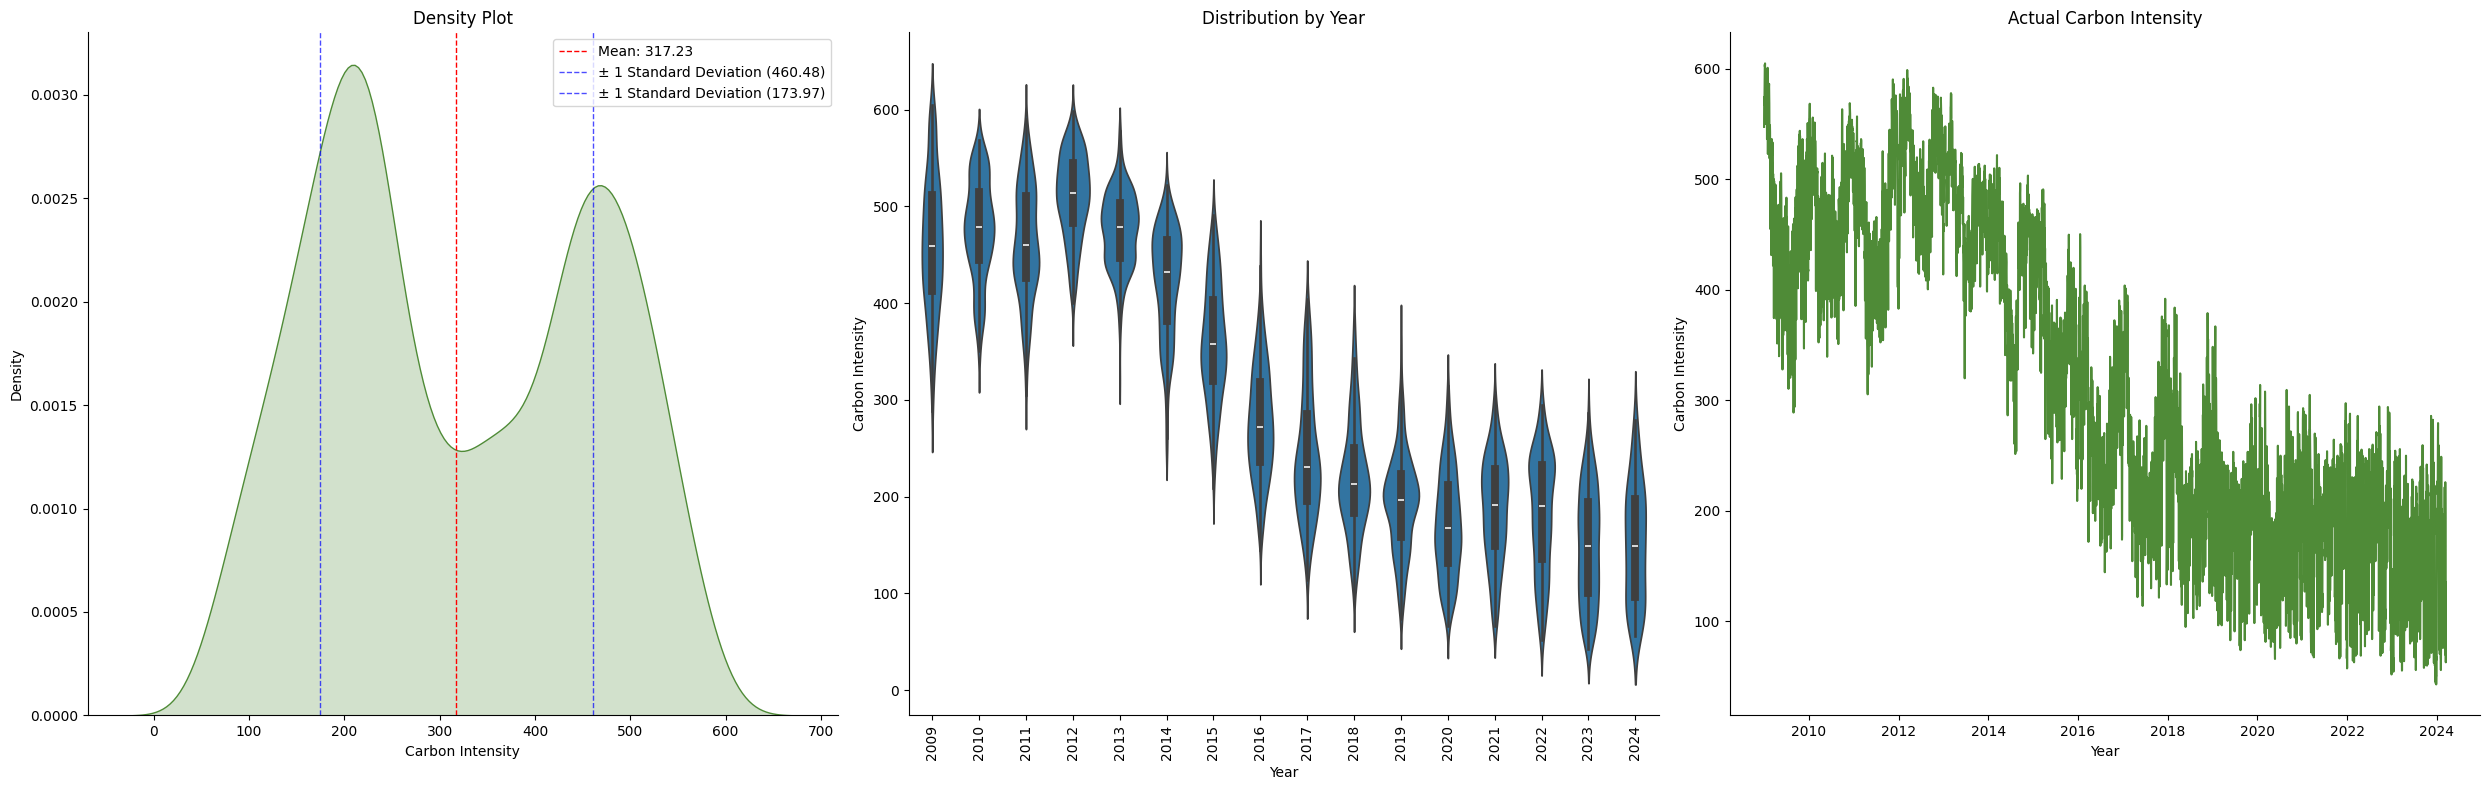

In [ ]:
# Create a figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 8))
# Density plot with custom color, shade, and x-axis rotation
df_resampled = df.copy().resample('D').median()
sns.kdeplot(data=df_resampled["CARBON_INTENSITY"], color="#4f8b37", shade=True, ax=ax1)  # Use specified color code and shade
ax1.set_xlabel("Carbon Intensity")  # Rotate x-axis labels for density plot only
ax1.set_ylabel("Density")
ax1.set_title("Density Plot")
ax1.grid(False)
ax1.tick_params(axis='x', rotation=0)
# Descriptive statistics on the density plot
mean_intensity = df_resampled["CARBON_INTENSITY"].mean()
std_intensity = df_resampled["CARBON_INTENSITY"].std()
ax1.axvline(mean_intensity, color='red', linestyle='dashed', linewidth=1, label=f"Mean: {mean_intensity:.2f}")
ax1.axvline(mean_intensity + std_intensity, color='blue', linestyle='dashed', linewidth=1, alpha=0.7,
            label=f"± 1 Standard Deviation ({(mean_intensity + std_intensity):.2f})")
ax1.axvline(mean_intensity - std_intensity, color='blue', linestyle='dashed', linewidth=1, alpha=0.7,
            label=f"± 1 Standard Deviation ({(mean_intensity - std_intensity):.2f})")
ax1.legend()

# Boxplot to show distribution and potential outliers (no rotation)
sns.violinplot(
    x=df_resampled.index.year,  # Replace with relevant categorical variable if applicable
    y=df_resampled['CARBON_INTENSITY'],
    # label = 'raw_data',
    data=df_resampled,
    ax=ax2,
)

ax2.set_xlabel("Year")  # Adjust label if using a different categorical variable
ax2.set_ylabel("Carbon Intensity")
ax2.set_title("Distribution by Year")
# ax2.legend(loc='upper right', bbox_to_anchor=(1.2, 1))
ax2.grid(False)
ax2.tick_params(axis='x', rotation=90)
# Time series plot with years on x-axis (assuming data has datetime index)
# Set major ticks for years
# Time series plot with actual dates on x-axis

ax3.plot(df_resampled.index, df_resampled["CARBON_INTENSITY"], linestyle="-",color="#4f8b37")
ax3.set_xlabel("Year")
ax3.set_ylabel("Carbon Intensity")
ax3.set_title("Actual Carbon Intensity")
ax3.grid(False)

plt.tight_layout()  # Adjust the layout to prevent overlapping
sns.despine()
plt.show()

<ipython-input-423-af7ba134b353>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected2['GENERATION'] = df.resample('1M').median()['GENERATION']/1000


<Figure size 2500x1000 with 0 Axes>

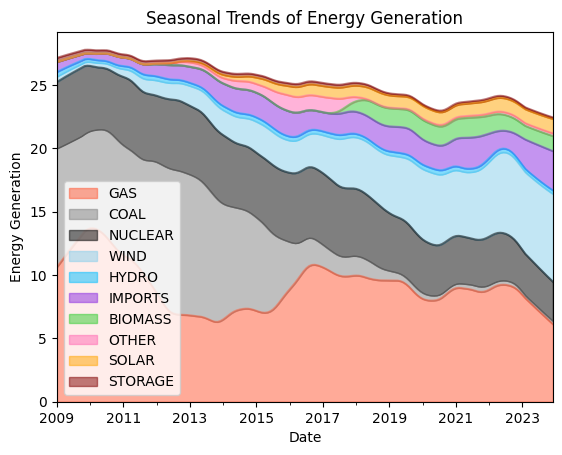

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import STL

# Define a custom color palette relevant to each feature
# Custom color palette
custom_palette = {
    'GAS': '#FF5733',       # Orange
    'COAL': '#808080',      # Gray
    'NUCLEAR': 'black',     # Black
    'WIND': '#87CEEB',      # Light blue
    'HYDRO': '#00BFFF',     # Deep sky blue
    'IMPORTS': '#8A2BE2',   # Blue violet
    'BIOMASS': '#32CD32',   # Lime green
    'OTHER': '#FF69B4',     # Hot pink
    'SOLAR': '#FFA500',     # Orange
    'STORAGE': '#800000',   # Maroon
}

# Select the columns of interest from df_all
columns_of_interest = ['GAS', 'COAL', 'NUCLEAR', 'WIND', 'HYDRO', 'IMPORTS', 'BIOMASS', 'OTHER', 'SOLAR', 'STORAGE']
df_selected = df_all[columns_of_interest]
df_selected2 = df_all[['GENERATION','Total electricity consumption']]

# Calculate the average for each month for the selected columns (excluding 'GENERATION')
monthly_avg = df_selected/2
df_selected2['GENERATION'] = df.resample('1M').median()['GENERATION']/1000

# Create a DataFrame to store all the seasonal trends
trend_df = pd.DataFrame()
trend_df2 = pd.DataFrame()
plt.figure(figsize=(25, 10))
# Iterate over each column
for column in monthly_avg.columns:
    # Decompose the time series data using STL
    stl_result = STL(monthly_avg[column], seasonal=13).fit()

    # Store the seasonal trend in the trend_df DataFrame
    trend_df[column] = stl_result.trend

for column in df_selected2.columns:
    # Decompose the time series data using STL
    stl_result = STL(df_selected2[column], seasonal=13).fit()

    # Store the seasonal trend in the trend_df DataFrame
    trend_df2[column] = stl_result.trend

# Plot the seasonal trends as an area plot
trend_df = trend_df.abs()
trend_df.plot(kind='area', alpha=0.5, color=[custom_palette[col] for col in trend_df.columns])

# Set the title and labels
plt.title('Seasonal Trends of Energy Generation')
plt.xlabel('Date')
plt.ylabel('Energy Generation')
plt.legend()
# Show the plot
plt.show()


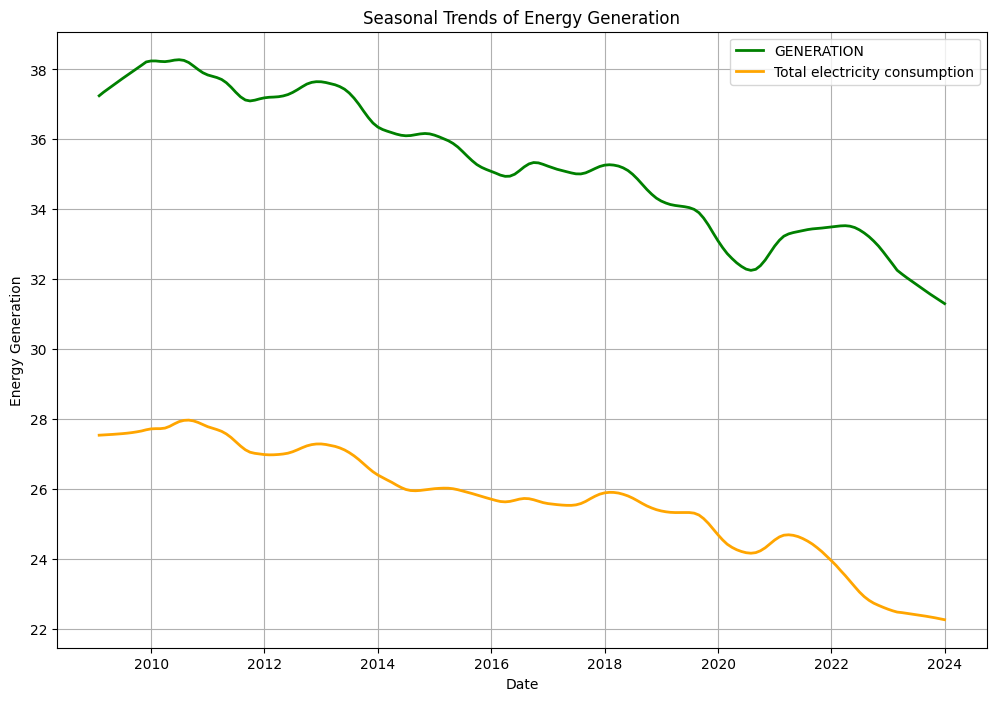

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the figure size
plt.figure(figsize=(12, 8))

for i, column in enumerate(trend_df2.columns):
    if i == 0:
        plt.plot(trend_df2.index, trend_df2[column], label=column, linewidth=2, color='green')
    else:
        plt.plot(trend_df2.index, trend_df2[column], label=column, linewidth=2, color='orange')

# Set the title and labels
plt.title('Seasonal Trends of Energy Generation')
plt.xlabel('Date')
plt.ylabel('Energy Generation')

# Add a legend
plt.legend()

# Show grid
plt.grid(True)

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# Sample DataFrame containing trend columns
# Let's assume you have a DataFrame called 'trend_df' with columns representing the trends


# Calculate slopes for each trend column
slopes = {}
for column in trend_df.columns:
    delta_y = trend_df[column].diff().dropna()  # Calculate the difference between consecutive values
    delta_x = (trend_df.index[1:] - trend_df.index[:-1]).days  # Calculate the difference in time (in days) between consecutive timestamps
    slope = delta_y / delta_x  # Calculate the slope for each time period
    mean_slope = slope.mean()  # Calculate the mean slope
    slopes[column] = mean_slope  # Store the mean slope in a dictionary
# Create lists of column names for positive and negative slopes
positive_slopes_columns = [column for column, slope in slopes.items() if slope > 0]
negative_slopes_columns = [column for column, slope in slopes.items() if slope < 0]

<Figure size 2500x800 with 0 Axes>

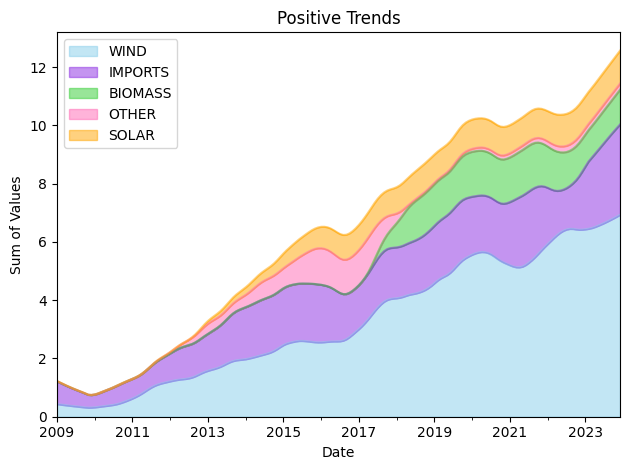

<Figure size 2000x800 with 0 Axes>

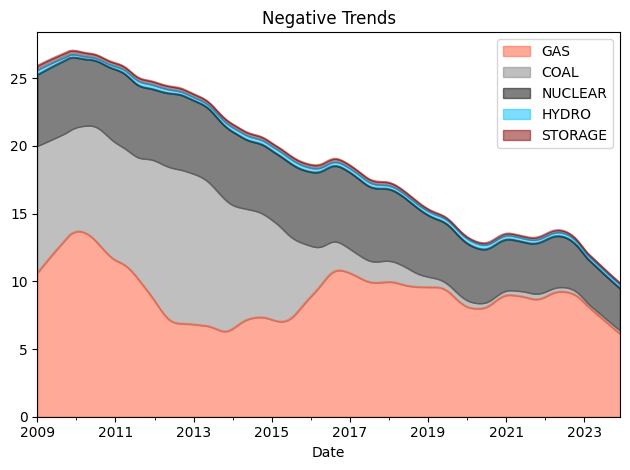

In [ ]:

# Create DataFrame for positive slopes and negative slopes
positive_trend_df = trend_df[positive_slopes_columns]
negative_trend_df = trend_df[negative_slopes_columns]

# Plot positive trends as area plot
plt.figure(figsize=(25, 8))
positive_trend_df.plot(kind='area', alpha=0.5, color=[custom_palette[col] for col in positive_trend_df.columns])

plt.title('Positive Trends')
plt.xlabel('Date')
plt.ylabel('Sum of Values')
plt.tight_layout()
plt.show()

# Plot negative trends as area plot
plt.figure(figsize=(20, 8))
negative_trend_df.plot(kind='area', alpha=0.5, color=[custom_palette[col] for col in negative_trend_df.columns])

plt.title('Negative Trends')
plt.xlabel('Date')
plt.tight_layout()
plt.show()

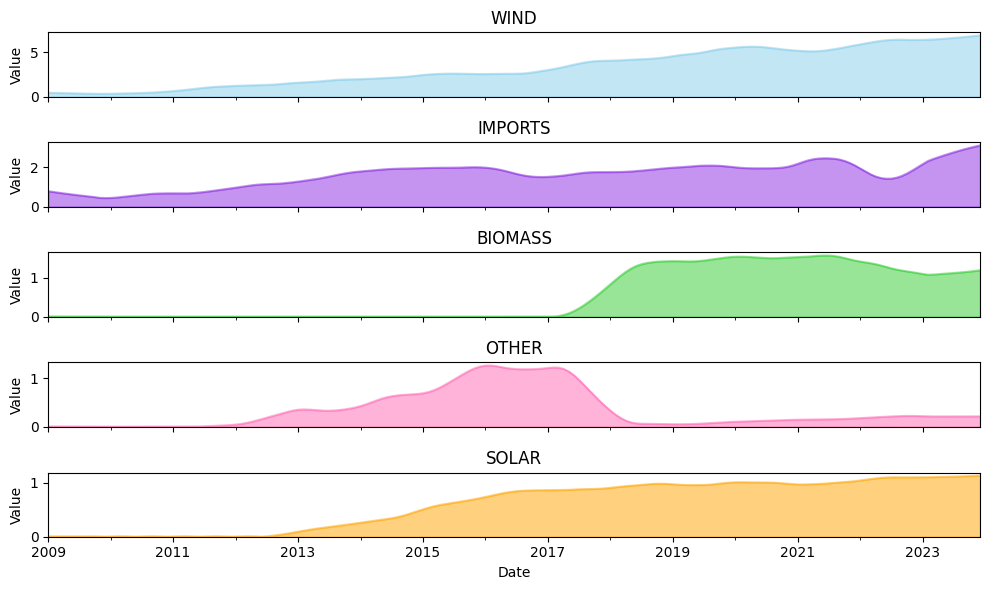

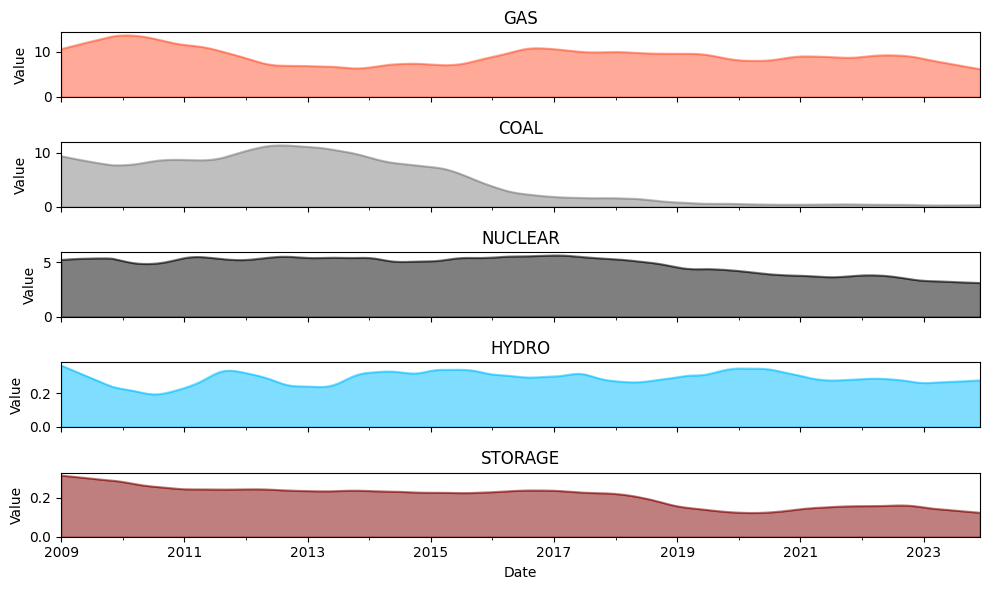

In [ ]:
# Plot positive trends as area plot with subplots
fig, axes = plt.subplots(len(positive_trend_df.columns), 1, figsize=(10, 6), sharex=True)
for i, column in enumerate(positive_trend_df.columns):
    positive_trend_df[column].plot(kind='area', alpha=0.5, color=custom_palette[column], ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_ylabel('Value')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()

# Plot negative trends as area plot with subplots
fig, axes = plt.subplots(len(negative_trend_df.columns), 1, figsize=(10, 6), sharex=True)
for i, column in enumerate(negative_trend_df.columns):
    negative_trend_df[column].plot(kind='area', alpha=0.5, color=custom_palette[column], ax=axes[i])
    axes[i].set_title(column)
    axes[i].set_ylabel('Value')
axes[-1].set_xlabel('Date')
plt.tight_layout()
plt.show()


# **4. Data Modelling**

Finding best model-feature set

(180, 232)
Performance Metrics (XGBoostRegressor):
╒════════════════════════════╤═══════════════════════╤══════════════════════╤═════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Feature Selection Method   │   Mean Absolute Error │   Mean Squared Error │   R^2 Score │ Selected Features                                                                                               │
╞════════════════════════════╪═══════════════════════╪══════════════════════╪═════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ SHAP                       │               10.7911 │              187.669 │    0.989851 │ Index(['SOLAR',                                                                                                 │
│                            │                       │                      │             │        'Water supply; Sewerage,wa

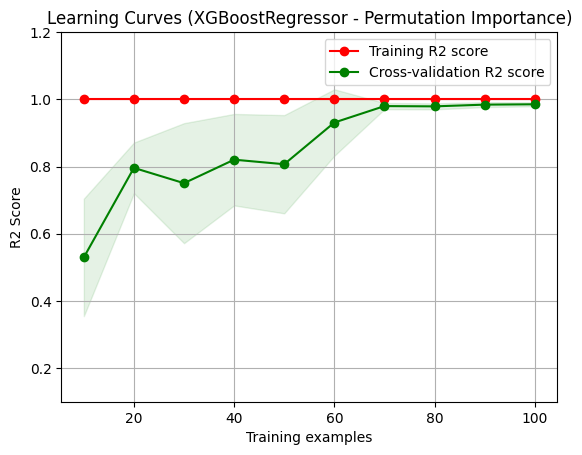

Performance Metrics (RandomForestRegressor):
╒════════════════════════════╤═══════════════════════╤══════════════════════╤═════════════╤══════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Feature Selection Method   │   Mean Absolute Error │   Mean Squared Error │   R^2 Score │ Selected Features                                                                                │
╞════════════════════════════╪═══════════════════════╪══════════════════════╪═════════════╪══════════════════════════════════════════════════════════════════════════════════════════════════╡
│ SHAP                       │               10.8035 │              190.674 │    0.989689 │ Index(['NUCLEAR', 'Gross Value Added - Monthly (Index 1dp) :CVM SA', 'OTHER',                    │
│                            │                       │                      │             │        'Other service activities (Index 1dp) :CVM SA', 'WIND',                                   │


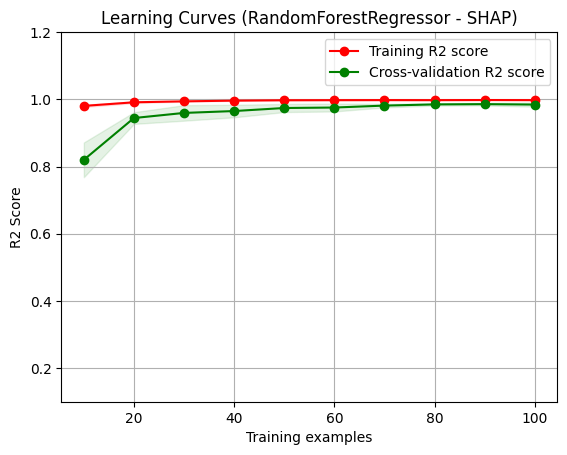

PermutationExplainer explainer: 127it [01:35,  1.23it/s]


Performance Metrics (GradientBoostingRegressor):
╒════════════════════════════╤═══════════════════════╤══════════════════════╤═════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Feature Selection Method   │   Mean Absolute Error │   Mean Squared Error │   R^2 Score │ Selected Features                                                                               │
╞════════════════════════════╪═══════════════════════╪══════════════════════╪═════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════╡
│ SHAP                       │                8.7694 │              137.775 │    0.992549 │ Index(['NUCLEAR',                                                                               │
│                            │                       │                      │             │        'Production Industries - Total (3m on 3m 1 year ago growth) :CVM SA',                    │
│

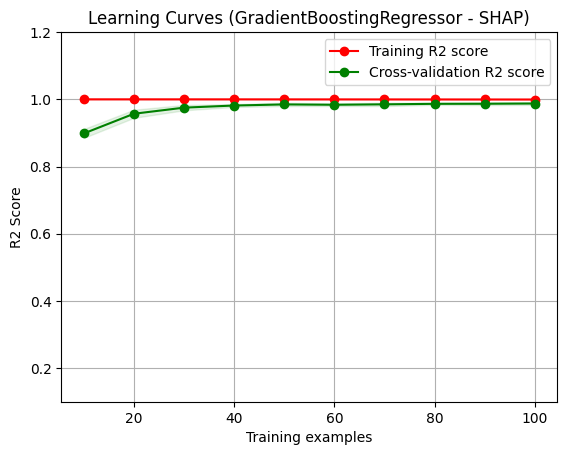

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.652e+02, tolerance: 2.186e+02
  model = cd_fast.enet_coordinate_descent(
PermutationExplainer explainer: 127it [01:44,  1.05it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.168e+04, tolerance: 2.186e+02
  model = cd_fast.enet_coordinate_descent(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing 

Performance Metrics (LASSO):
╒════════════════════════════╤═══════════════════════╤══════════════════════╤═════════════╤═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Feature Selection Method   │   Mean Absolute Error │   Mean Squared Error │   R^2 Score │ Selected Features                                                                                                 │
╞════════════════════════════╪═══════════════════════╪══════════════════════╪═════════════╪═══════════════════════════════════════════════════════════════════════════════════════════════════════════════════╡
│ SHAP                       │               10.0543 │              143.116 │    0.992261 │ Index(['Agriculture, Forestry and Fishing (period on period 1 year ago contribution ) :CVM SA',                   │
│                            │                       │                      │             │        'Administrative and Support Service Acti

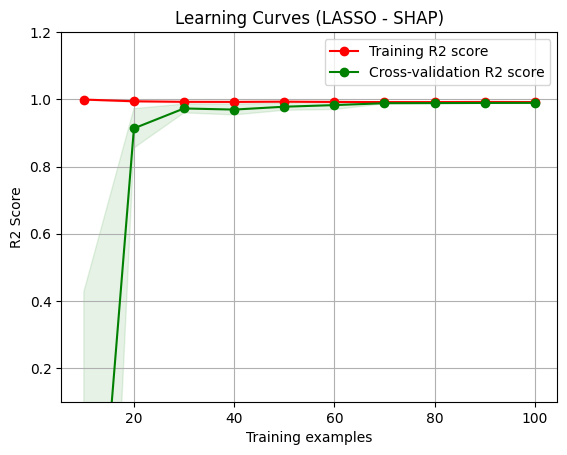

PermutationExplainer explainer: 127it [02:18,  1.18s/it]


Performance Metrics (KNNRegressor):
╒════════════════════════════╤═══════════════════════╤══════════════════════╤═════════════╤═════════════════════════════════════════════════════════════════════════════════════════════════╕
│ Feature Selection Method   │   Mean Absolute Error │   Mean Squared Error │   R^2 Score │ Selected Features                                                                               │
╞════════════════════════════╪═══════════════════════╪══════════════════════╪═════════════╪═════════════════════════════════════════════════════════════════════════════════════════════════╡
│ SHAP                       │               14.6454 │              404.1   │    0.978147 │ Index(['Professional, scientific and technical activities (Index 1dp) :CVM SA',                 │
│                            │                       │                      │             │        'SOLAR',                                                                                 │
│             

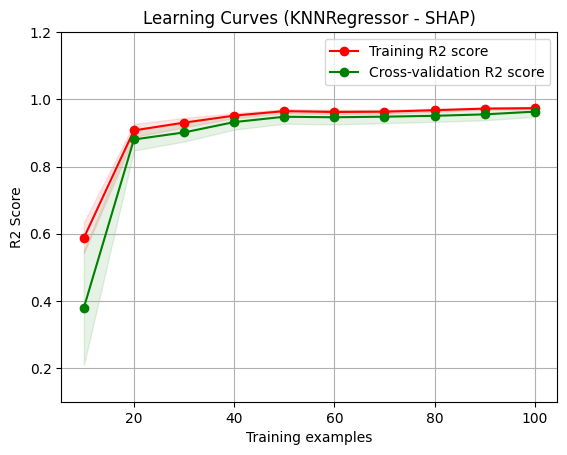

In [ ]:
# Load data
data = merged_data_new.copy()

# Preprocess data
data['MONTH'] = data['MONTH'].apply(lambda x: str(x).zfill(2))
data['date'] = pd.to_datetime(data['YEAR'].astype(str) + '-' + data['MONTH'] + '-28')
data.drop(columns=['YEAR', 'MONTH'], inplace=True)
data.set_index('date', inplace=True)
print(data.shape)
# Generate synthetic data
X = data.drop(columns=['CARBON_INTENSITY'])
y = data['CARBON_INTENSITY']

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=11)

# Scale features
scaler = MinMaxScaler(feature_range=(0, 600))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define a function to train and evaluate a model
def train_evaluate_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mae, mse, r2

# Define a function to calculate feature importances
def calculate_feature_importances(model, X_train, y_train):
    explainer = shap.Explainer(model, X_train)
    shap_values = explainer.shap_values(X_train)
    shap_feature_importance = np.abs(shap_values).mean(0)
    top_10_shap_features = np.argsort(shap_feature_importance)[-10:]
    mutual_info = mutual_info_regression(X_train, y_train)
    top_10_mutual_info_features = np.argsort(mutual_info)[-10:]
    perm_importance = permutation_importance(model, X_train, y_train, n_repeats=10)
    top_10_perm_importance_features = np.argsort(perm_importance.importances_mean)[-10:]
    return top_10_shap_features, top_10_mutual_info_features, top_10_perm_importance_features


# Define a function to train and evaluate a model and check for overfitting
def train_evaluate_model_with_overfitting_check(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)

    # Calculate training error
    y_train_pred = model.predict(X_train)
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_mse = mean_squared_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)

    # Evaluate on test set
    y_pred = model.predict(X_test)
    test_mae = mean_absolute_error(y_test, y_pred)
    test_mse = mean_squared_error(y_test, y_pred)
    test_r2 = r2_score(y_test, y_pred)


    return train_mae, train_mse, train_r2, test_mae, test_mse, test_r2


# Define a function to plot learning curves
def plot_learning_curves(model, X_train, y_train, model_name, ylim=(0.1, 1.2)):
    train_sizes, train_scores, test_scores = learning_curve(
        model, X_train, y_train, cv=5, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10)
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure()
    plt.title(f"Learning Curves ({model_name})")
    plt.xlabel("Training examples")
    plt.ylabel("R2 Score")
    plt.grid()

    if ylim is not None:
        plt.ylim(ylim)

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training R2 score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation R2 score")

    plt.legend(loc="best")
    plt.show()



# Modify the hyperparameters for the models considering the small dataset
models = {
  'XGBoostRegressor': xgb.XGBRegressor(n_estimators=50, random_state=11),
  'RandomForestRegressor': RandomForestRegressor(n_estimators=50, random_state=11),
  'GradientBoostingRegressor': GradientBoostingRegressor(n_estimators=50, random_state=11),
  'LASSO': Lasso(alpha=0.5, random_state=11),
  'KNNRegressor': KNeighborsRegressor(n_neighbors=7)
}


# Evaluate models and print results for each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_scaled, y_train)

    # Use TreeExplainer for tree-based models and Explainer for linear models
    if model_name in ['XGBoostRegressor', 'RandomForestRegressor', 'GradientBoostingRegresso']:
        explainer = shap.TreeExplainer(model)
    else:
        explainer = shap.Explainer(model.predict, X_train_scaled)

    shap_values = explainer.shap_values(X_train_scaled)
    shap_feature_importance = np.abs(shap_values).mean(0)
    top_10_shap_features = np.argsort(shap_feature_importance)[-10:]

    mutual_info = mutual_info_regression(X_train_scaled, y_train)
    top_10_mutual_info_features = np.argsort(mutual_info)[-10:]

    perm_importance = permutation_importance(model, X_train_scaled, y_train, n_repeats=10, )
    top_10_perm_importance_features = np.argsort(perm_importance.importances_mean)[-10:]

    # Select top 10 features based on each method
    X_train_shap = X_train_scaled[:, top_10_shap_features]
    X_test_shap = X_test_scaled[:, top_10_shap_features]

    X_train_mutual_info = X_train_scaled[:, top_10_mutual_info_features]
    X_test_mutual_info = X_test_scaled[:, top_10_mutual_info_features]

    X_train_perm = X_train_scaled[:, top_10_perm_importance_features]
    X_test_perm = X_test_scaled[:, top_10_perm_importance_features]

    # Evaluate model with SHAP selected features
    mae_shap, mse_shap, r2_shap = train_evaluate_model(model, X_train_shap, X_test_shap, y_train, y_test, 'SHAP')

    # Evaluate model with Mutual Information selected features
    mae_mutual_info, mse_mutual_info, r2_mutual_info = train_evaluate_model(model, X_train_mutual_info, X_test_mutual_info, y_train, y_test, 'Mutual Information')

    # Evaluate model with Permutation Importance selected features
    mae_perm, mse_perm, r2_perm = train_evaluate_model(model, X_train_perm, X_test_perm, y_train, y_test, 'Permutation Importance')

    # Create a dataframe to store the results for each model
    results_df = pd.DataFrame({
        'Feature Selection Method': ['SHAP', 'Mutual Information', 'Permutation Importance'],
        'Mean Absolute Error': [mae_shap, mae_mutual_info, mae_perm],
        'Mean Squared Error': [mse_shap, mse_mutual_info, mse_perm],
        'R^2 Score': [r2_shap, r2_mutual_info, r2_perm],
        'Selected Features': [
            X.columns[top_10_shap_features],
            X.columns[top_10_mutual_info_features],
            X.columns[top_10_perm_importance_features]
        ]
    })

    # Print the results for each model
    print(f"Performance Metrics ({model_name}):")
    print(tabulate(results_df, headers='keys', tablefmt='fancy_grid', showindex=False))

    # Evaluate model with SHAP selected features
    results_shap = train_evaluate_model_with_overfitting_check(model, X_train_shap, X_test_shap, y_train, y_test, 'SHAP')

    # Evaluate model with Mutual Information selected features
    results_mutual_info = train_evaluate_model_with_overfitting_check(model, X_train_mutual_info, X_test_mutual_info, y_train, y_test, 'Mutual Information')

    # Evaluate model with Permutation Importance selected features
    results_perm = train_evaluate_model_with_overfitting_check(model, X_train_perm, X_test_perm, y_train, y_test, 'Permutation Importance')

    # Determine the best feature selection method for each model based on test MSE
    best_feature_method = None
    if results_shap[4] < results_mutual_info[4] and results_shap[4] < results_perm[4]:
        best_feature_method = 'SHAP'
    elif results_mutual_info[4] < results_shap[4] and results_mutual_info[4] < results_perm[4]:
        best_feature_method = 'Mutual Information'
    else:
        best_feature_method = 'Permutation Importance'

    # Select the features based on the best feature selection method
    if best_feature_method == 'SHAP':
        X_train_best = X_train_shap
    elif best_feature_method == 'Mutual Information':
        X_train_best = X_train_mutual_info
    else:
        X_train_best = X_train_perm

    # Print the results for each model
    print(f"Performance Metrics ({model_name}):")
    print("Best Feature Selection Method for Learning Curve:", best_feature_method)
    print("-----------------------------------------------------------")
    print("Train MAE:", results_shap[0])
    print("Test MAE:", results_shap[3])
    print("Train MSE:", results_shap[1])
    print("Test MSE:", results_shap[4])
    print("Train R^2:", results_shap[2])
    print("Test R^2:", results_shap[5])
    print("Selected Features:", X.columns[top_10_shap_features])
    print("-----------------------------------------------------------")

    # Plot learning curve for the best feature selection method
    plot_learning_curves(model, X_train_best, y_train, f"{model_name} - {best_feature_method}")

Checking the feature importance using best performing model-feature pair

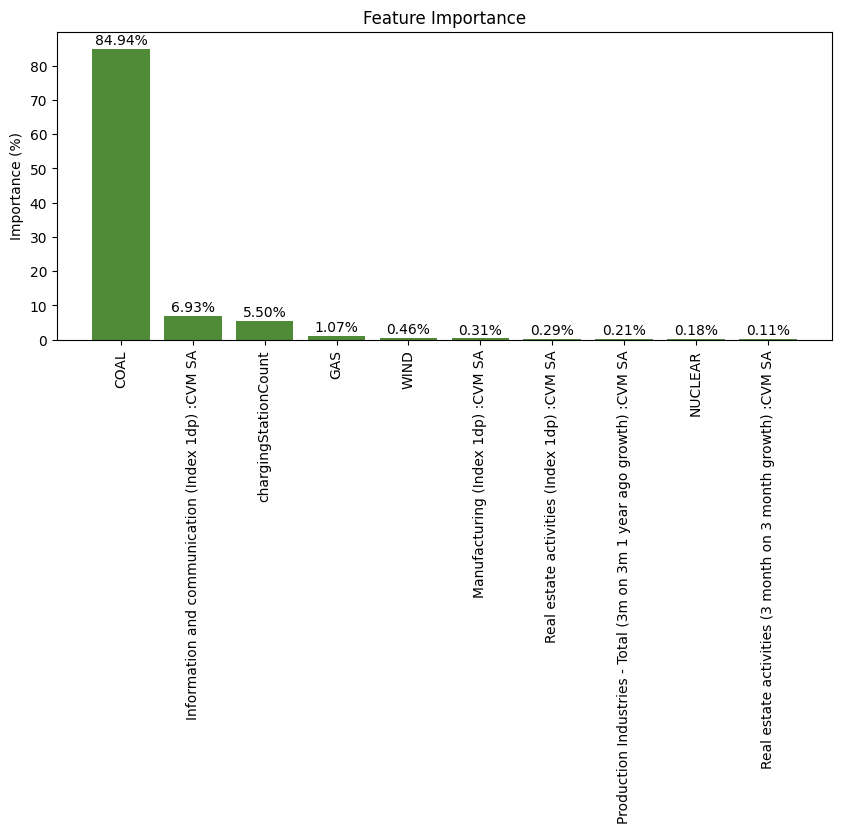

In [ ]:
# Define the features and the target
features = ['NUCLEAR', 'Production Industries - Total (3m on 3m 1 year ago growth) :CVM SA',
            'Real estate activities (3 month on 3 month growth) :CVM SA',
            'Manufacturing (Index 1dp) :CVM SA', 'Real estate activities (Index 1dp) :CVM SA',
            'WIND', 'GAS', 'chargingStationCount',
            'Information and communication (Index 1dp) :CVM SA', 'COAL']
target = 'CARBON_INTENSITY'

X_train_scaled_final = X_train_scaled[:, [X.columns.get_loc(feature) for feature in features]]
X_test_scaled_final = X_test_scaled[:, [X.columns.get_loc(feature) for feature in features]]

# Define a function to plot feature importance
def plot_feature_importance(model, feature_names):
    # Fit the model
    model.fit(X_train_scaled_final, y_train)

    # Get feature importances
    importances = model.feature_importances_
    # Sort the feature importances in descending order
    indices = np.argsort(importances)[::-1]
    # Rearrange feature names so they match the sorted feature importances
    names = [feature_names[i] for i in indices]
    # Create a bar plot
    plt.figure(figsize=(10, 4))
    bars = plt.bar(range(len(importances)), importances[indices] * 100, color='#4f8b37')  # Convert to percentage
    plt.title("Feature Importance")
    plt.xticks(range(len(importances)), names, rotation=90)
    plt.ylabel('Importance (%)')  # Change y-axis label to percentage
    plt.ylim(0, max(importances[indices] * 100) + 5)  # Adjust y-axis limits

    # Add the values on top of the bars
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + 0.5, f'{yval:.2f}%', ha='center', va='bottom')  # Add percentage symbol)

# Initialize the GradientBoostingRegressor
model_new = GradientBoostingRegressor(n_estimators=50, random_state=11)

# Assuming X_train and y_train are already defined and contain the training data
# Fit the model (this part is just a placeholder, the actual fitting should be done with real data)
model_new.fit(X_train_scaled_final, y_train)

# Call the function to plot feature importance (this part is also a placeholder, the actual model should be trained with real data)
plot_feature_importance(model_new, features)

Checking the trend

['COAL', 'chargingStationCount', 'Information and communication (Index 1dp) :CVM SA', 'Real estate activities (Index 1dp) :CVM SA', 'GAS', 'WIND', 'NUCLEAR', 'Manufacturing (Index 1dp) :CVM SA', 'Production Industries - Total (3m on 3m 1 year ago growth) :CVM SA', 'Real estate activities (3 month on 3 month growth) :CVM SA']


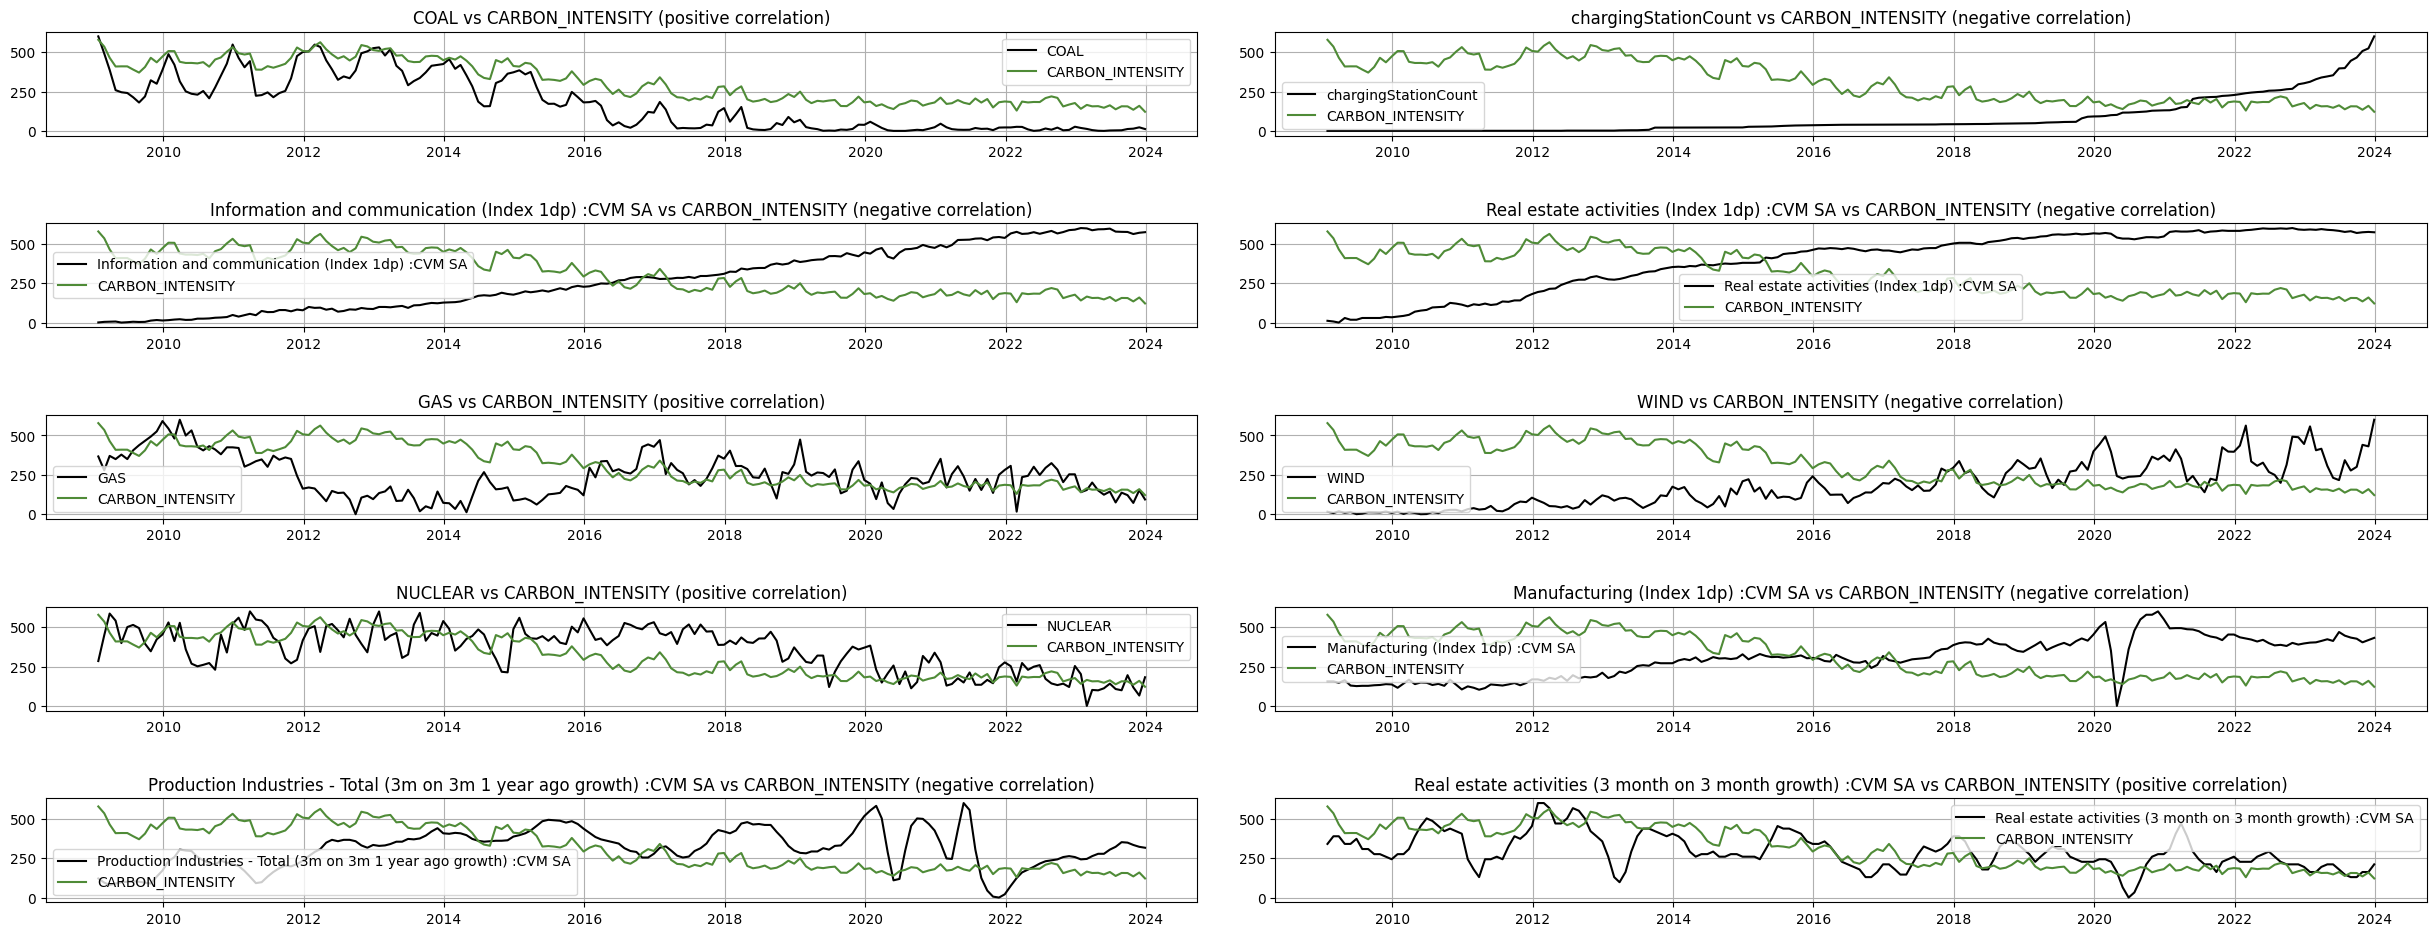

In [ ]:
target_variable = "CARBON_INTENSITY"
tred_data = data
# Feature scaling
scaler = MinMaxScaler(feature_range=(0, 600))
tred_data[features] = scaler.fit_transform(tred_data[features])

# Feature importance with Random Forest
rf =  GradientBoostingRegressor(n_estimators=50, random_state=11)
rf.fit(tred_data[features], tred_data[target_variable])
importances = pd.Series(rf.feature_importances_, index=features)
top_10_features = importances.sort_values(ascending=False).head(10).index.tolist()
print(top_10_features)

# Create a figure with subplots for top 5 features vs target variable
fig, axes = plt.subplots(5, 2, figsize=(25, 10))  # Adjust layout as needed

# Iterate through top 5 features
i, j = 0, 0
for feature in top_10_features:
    # Calculate correlation
    correlation = data[feature].corr(data[target_variable])
    effect = "positive" if correlation > 0 else "negative"

    # Plot feature vs target variable (time series)
    axes[i, j].plot(data.index, data[feature], label=feature, color="black")
    axes[i, j].plot(data.index, data[target_variable], label=target_variable, color="#4f8b37")
    axes[i, j].set_title(f"{feature} vs {target_variable} ({effect} correlation)")
    axes[i, j].legend()
    axes[i, j].grid(True)

    # Move to the next subplot
    j += 1
    if j > 1:
        i += 1
        j = 0

plt.tight_layout(pad=3.0)
plt.show()



Feature Impact

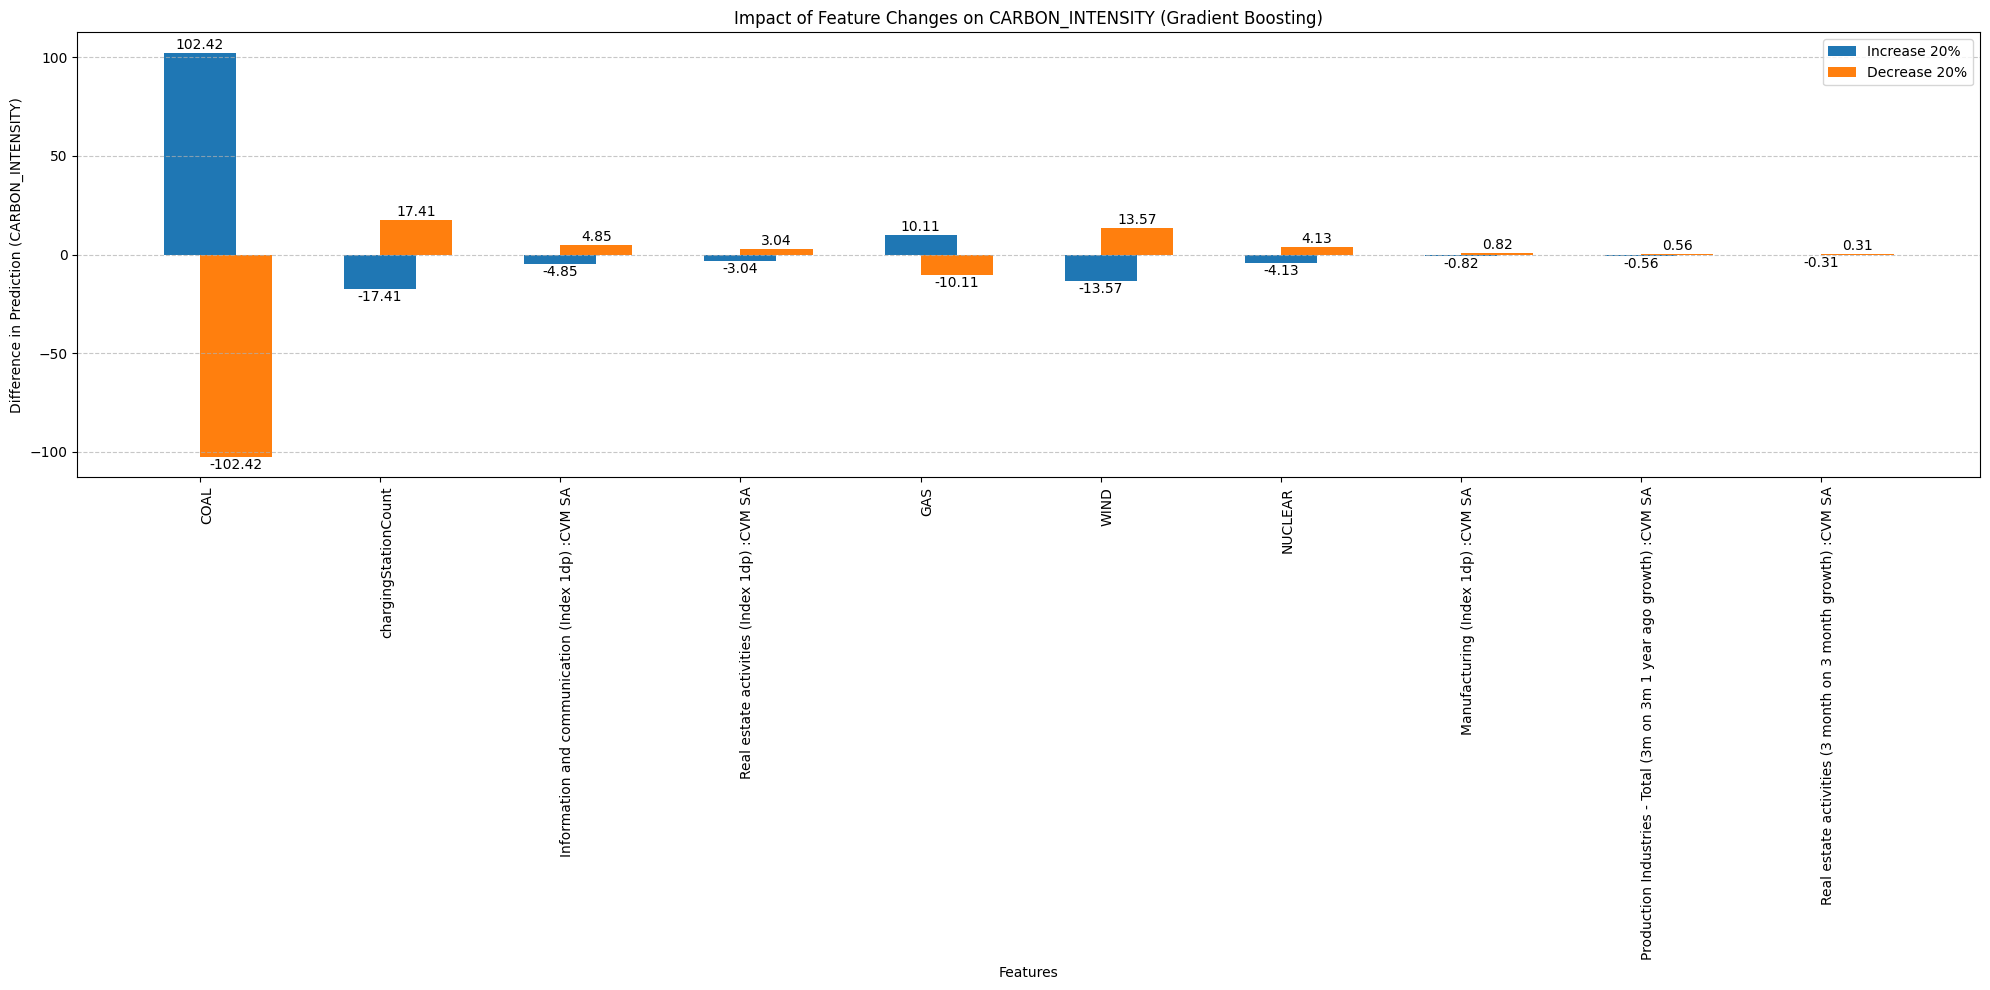

In [ ]:
def visualize_feature_impact(data, features, target, model):

  data_copy = data.copy()
  impact_data = []  # List to store change percentages and prediction differences

  for feature in features:
    # Increase and decrease feature values by 20%
    increased_value = data_copy[feature] * 20.0
    decreased_value = data_copy[feature] * 20.0

    # Set feature values to increased and decreased values for prediction
    data_copy[feature] = increased_value
    increased_prediction = model.predict(data_copy[features])
    data_copy[feature] = decreased_value
    decreased_prediction = model.predict(data_copy[features])

    # Reset feature value to original value
    data_copy[feature] = data[feature]

    # Calculate average difference in prediction for increase and decrease
    avg_increase_diff = increased_prediction.mean() - model.predict(data[features]).mean()
    avg_decrease_diff = model.predict(data[features]).mean() - decreased_prediction.mean()

    # Store change percentages and prediction differences
    impact_data.append({
      'feature': feature,
      'increase_pct': 20.0,
      'increase_diff': avg_increase_diff,
      'decrease_pct': -20.0,
      'decrease_diff': avg_decrease_diff
    })

  # Create a DataFrame from impact data
  impact_df = pd.DataFrame(impact_data)

  # Visualize impact using bar chart
  plt.figure(figsize=(20, 10))
  plt.bar(impact_df['feature'], impact_df['increase_diff'], label='Increase 20%', width=0.4, align='center')
  plt.bar(impact_df['feature'], impact_df['decrease_diff'], label='Decrease 20%', width=0.4, align='edge')
  plt.xticks(rotation=90, ha='left')
  plt.xlabel('Features')
  plt.ylabel('Difference in Prediction (CARBON_INTENSITY)')
  plt.title('Impact of Feature Changes on CARBON_INTENSITY (Gradient Boosting)')
  plt.legend()
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.tight_layout()

  # Add values on top of the bars
  for i, bar in enumerate(plt.gca().patches):
    value = bar.get_height()
    if value >= 0:
      plt.text(bar.get_x() + bar.get_width() / 2, value + 0.5, f'{value:.2f}', ha='center', va='bottom')
    else:
      plt.text(bar.get_x() + bar.get_width() / 2, value - 0.5, f'{value:.2f}', ha='center', va='top')

  plt.show()

# Example usage (assuming you have your data in a DataFrame named 'data')
features = top_10_features
target = 'CARBON_INTENSITY'
model = GradientBoostingRegressor(n_estimators=50, random_state=11)  # Assuming your trained model
model.fit(data.loc[:,features], data[target])
visualize_feature_impact(data, features, target, model)


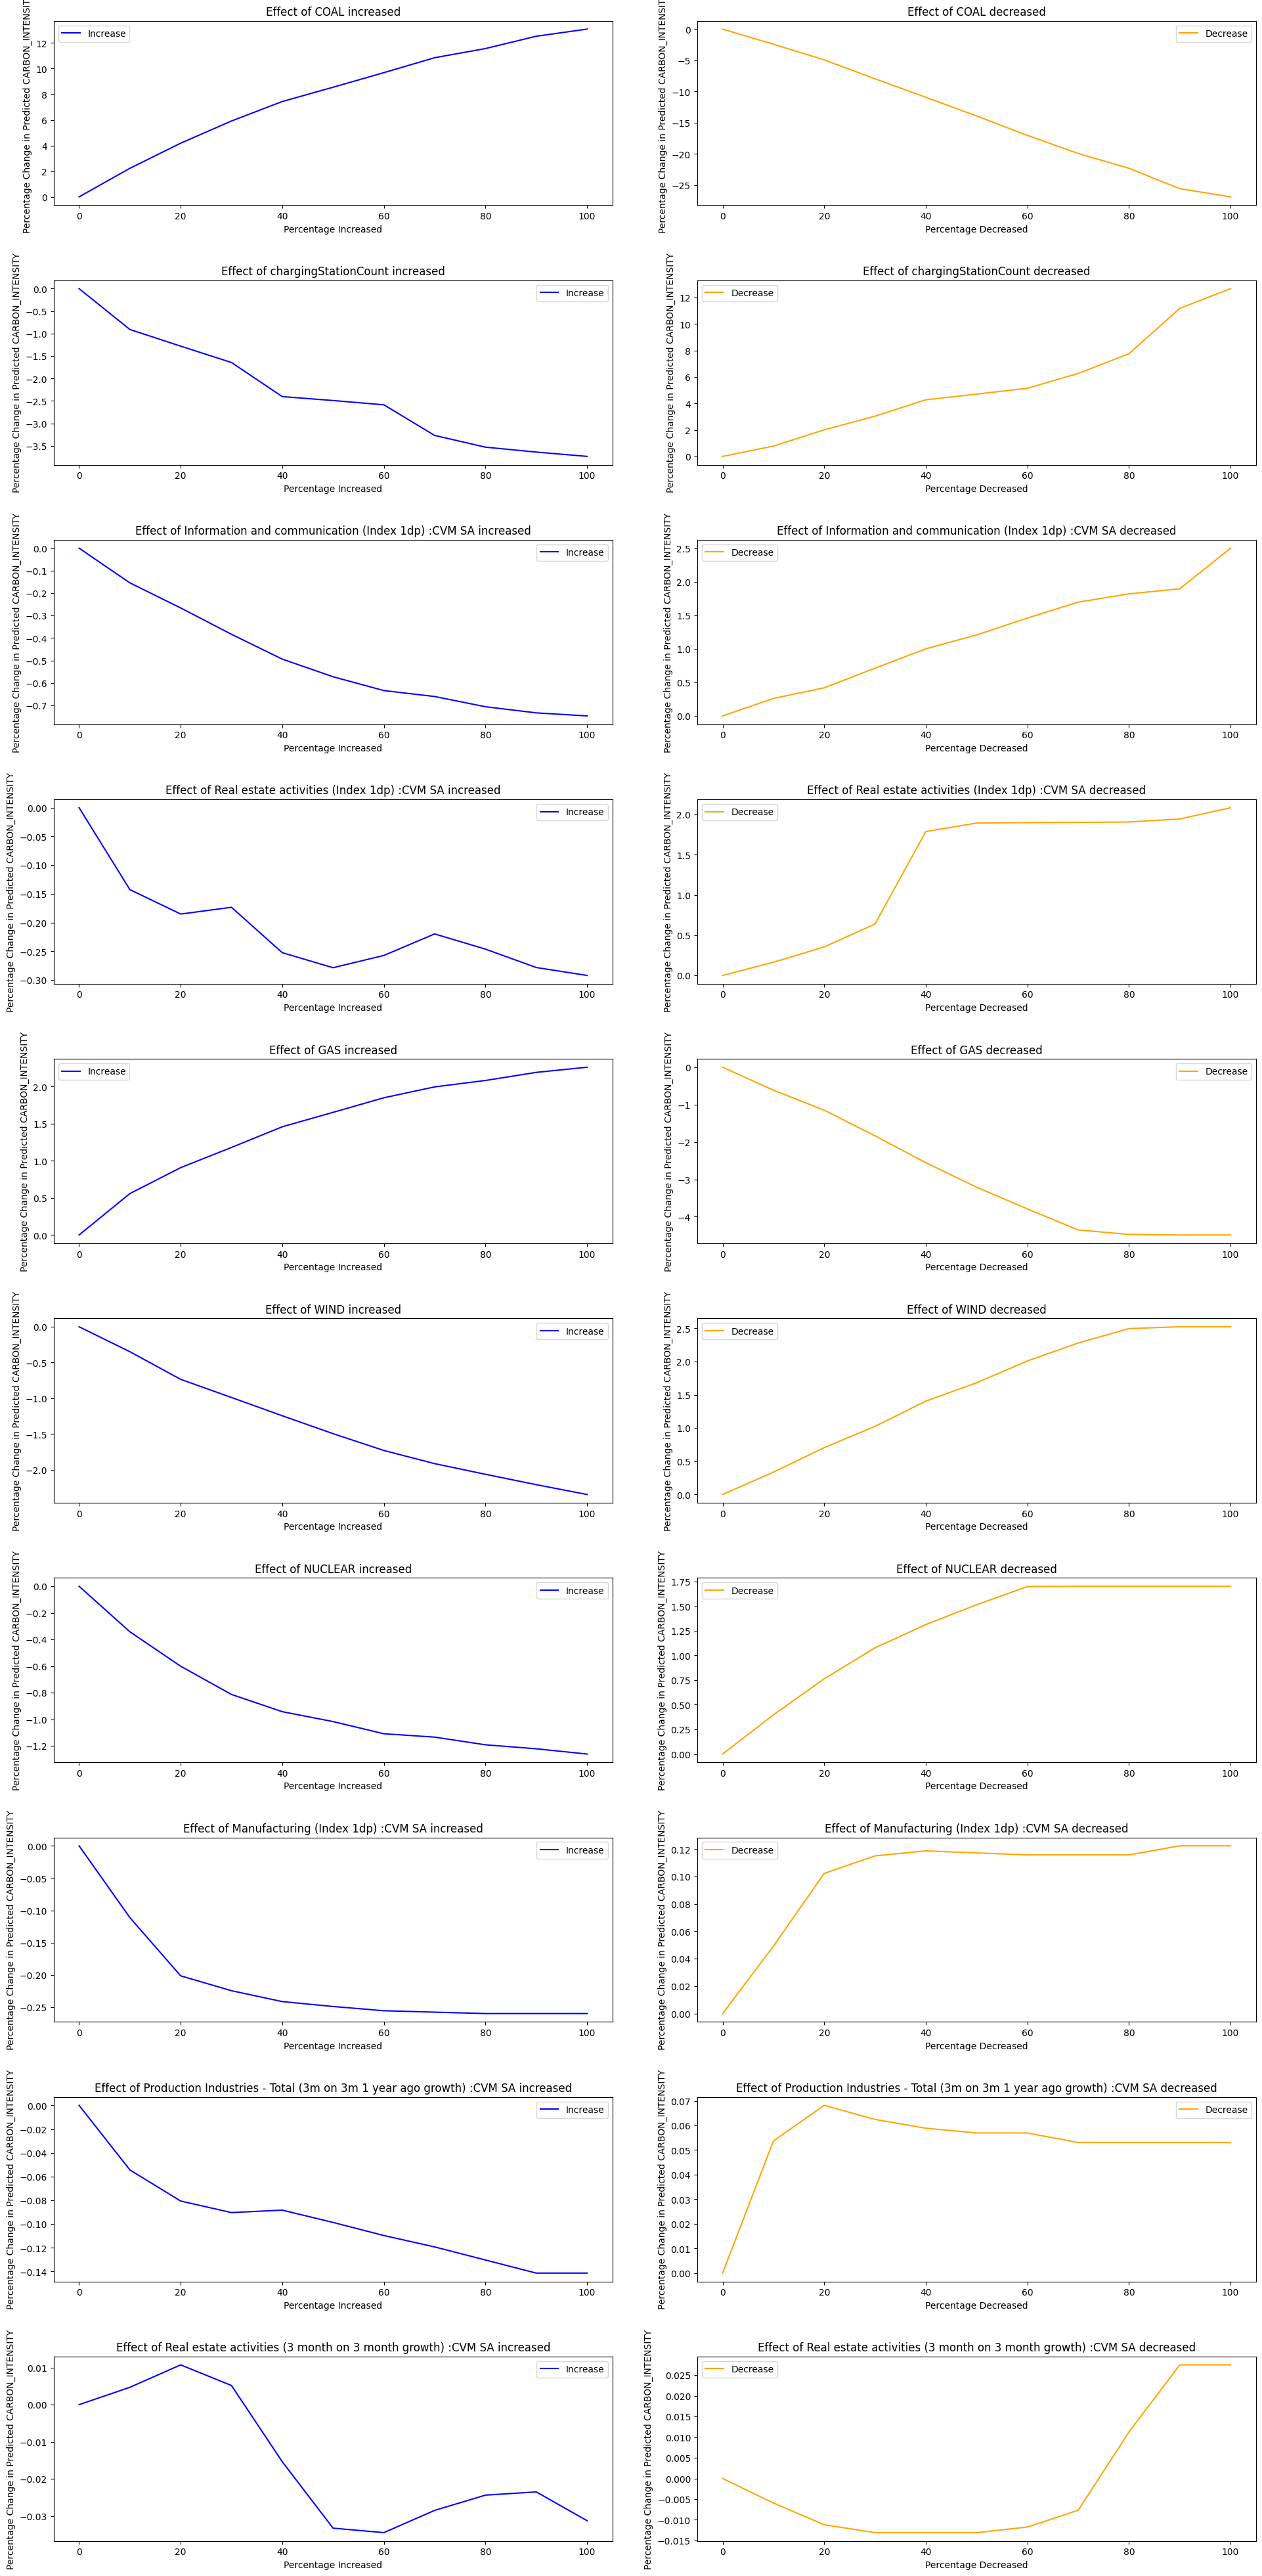

In [ ]:
def visualize_feature_impact(data, features, target, model):
    # Copy the data to avoid modifying the original DataFrame
    data_copy = data.copy()
    percentage_changes = np.arange(0.0, 1.1, 0.1)  # From 0% to +100% in steps of 10%

    # Create a figure and axes for the plots
    fig, axes = plt.subplots(len(features), 2, figsize=(20, 4 * len(features)))

    for idx, feature in enumerate(features):
        original_prediction = model.predict(data[features]).mean()  # Original prediction with unchanged feature

        increase_percentage = []
        decrease_percentage = []

        for pct_change in percentage_changes:
            # Increase feature value by the percentage change
            increased_data = data_copy.copy()
            increased_data[feature] *= (1 + pct_change)
            # Predict with the modified data
            increase_prediction = model.predict(increased_data[features]).mean()
            # Calculate percentage change in prediction
            increase_percentage.append(((increase_prediction - original_prediction) / original_prediction) * 100)

            # Decrease feature value by the percentage change
            decreased_data = data_copy.copy()
            decreased_data[feature] *= (1 - pct_change)
            # Predict with the modified data
            decrease_prediction = model.predict(decreased_data[features]).mean()
            # Calculate percentage change in prediction
            decrease_percentage.append(((decrease_prediction - original_prediction) / original_prediction) * 100)

        # Plot the impact of feature change on the target for both increase and decrease
        axes[idx, 0].plot(percentage_changes * 100, increase_percentage, label='Increase', color='blue')
        axes[idx, 0].set_title(f'Effect of {feature} increased')
        axes[idx, 0].set_xlabel('Percentage Increased')
        axes[idx, 0].set_ylabel('Percentage Change in Predicted ' + target)
        axes[idx, 0].legend()

        axes[idx, 1].plot(percentage_changes * 100, decrease_percentage, label='Decrease', color='orange')
        axes[idx, 1].set_title(f'Effect of {feature} decreased')
        axes[idx, 1].set_xlabel('Percentage Decreased')
        axes[idx, 1].set_ylabel('Percentage Change in Predicted ' + target)
        axes[idx, 1].legend()

    # Adjust layout
    plt.tight_layout(pad=3.5)
    plt.show()

# Example usage
visualize_feature_impact(data, features, target, model)

Effect of COAL alone

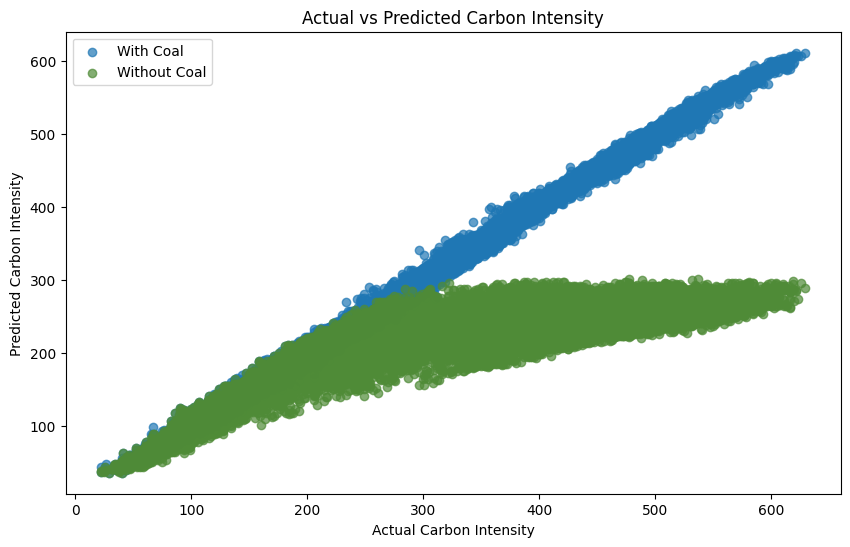

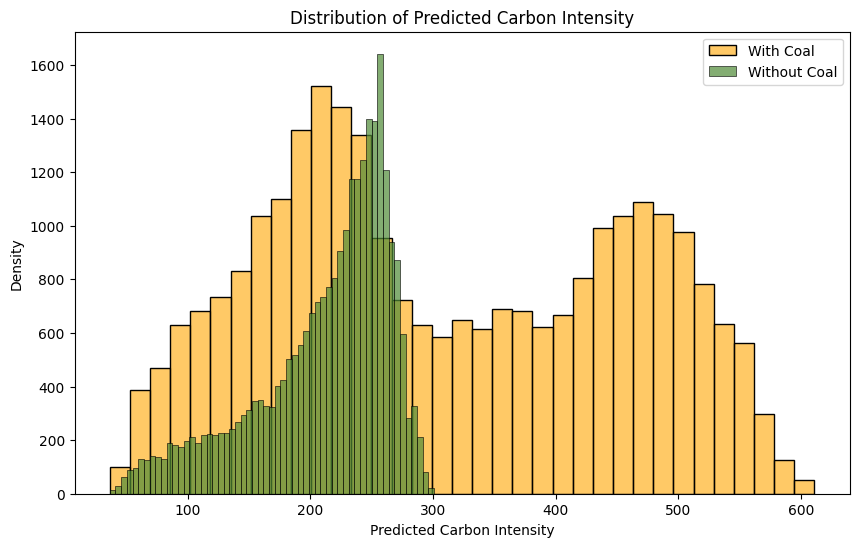

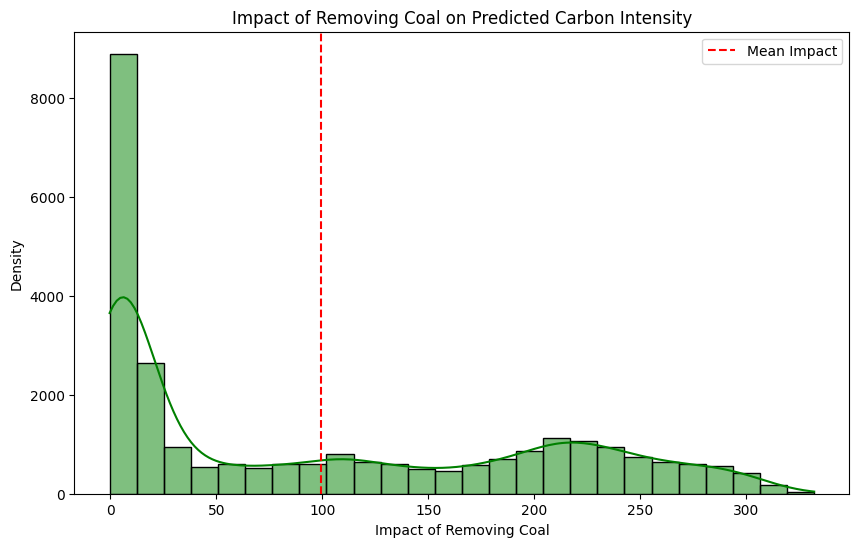

In [ ]:
# Step 1: Plot actual carbon intensity against predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_with_all_features, label='With Coal', alpha=0.7)
plt.scatter(y_test, y_pred_with_coal_0, label='Without Coal',color = '#4f8b37', alpha=0.7)
plt.xlabel('Actual Carbon Intensity')
plt.ylabel('Predicted Carbon Intensity')
plt.title('Actual vs Predicted Carbon Intensity')
plt.legend()
plt.show()

# Step 2: Compare distributions of predicted carbon intensity values
plt.figure(figsize=(10, 6))
sns.histplot(y_pred_with_all_features, label='With Coal', color='orange', alpha=0.6)
sns.histplot(y_pred_with_coal_0, label='Without Coal', color='#4f8b37', alpha=0.7)
plt.xlabel('Predicted Carbon Intensity')
plt.ylabel('Density')
plt.title('Distribution of Predicted Carbon Intensity')
plt.legend()
plt.show()

# Step 3: Visualize the impact of removing coal
impact = y_pred_with_all_features - y_pred_with_coal_0

plt.figure(figsize=(10, 6))
sns.histplot(impact, color='green', kde=True)
plt.xlabel('Impact of Removing Coal')
plt.ylabel('Density')
plt.title('Impact of Removing Coal on Predicted Carbon Intensity')
plt.axvline(np.mean(impact), color='red', linestyle='--', label='Mean Impact')
plt.legend()
plt.show()


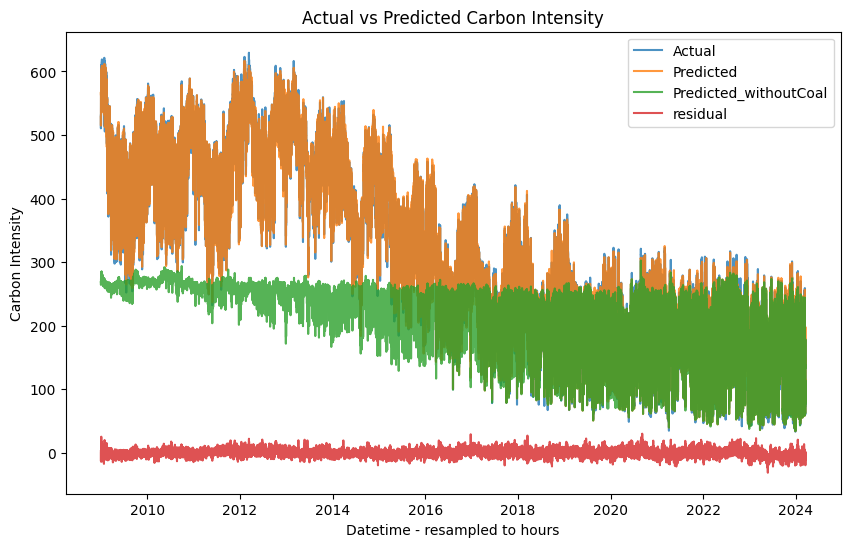

In [ ]:
import matplotlib.pyplot as plt

# Assuming y_test contains the actual carbon intensity values for the test set

plt.figure(figsize=(10, 6))
# Plot the actual carbon intensity
plt.plot(df_y_values, alpha = 0.8)
# Set labels and title
plt.xlabel('Datetime - resampled to hours')
plt.ylabel('Carbon Intensity')
plt.title('Actual vs Predicted Carbon Intensity')
plt.legend(df_y_values.columns)
plt.show()



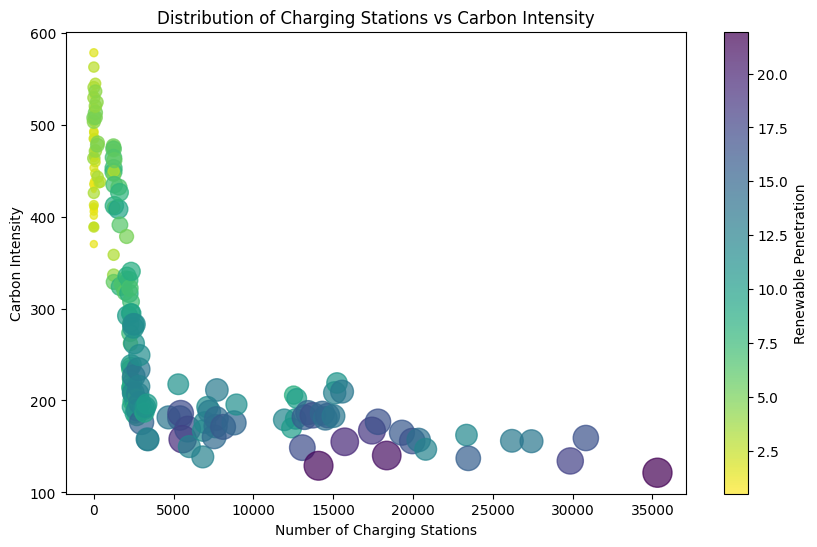

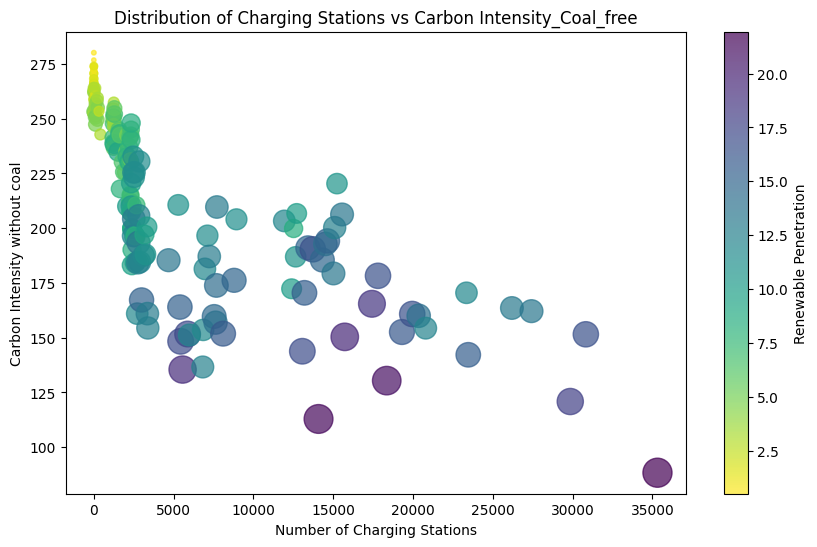

In [ ]:
import matplotlib.pyplot as plt

# Define the data for the scatter plot
scatter_df = df_all[['chrgingStationCount', 'CARBON_INTENSITY', 'RENEWABLE','IMPORTS','carbon_intensity_without_coal']]

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scatter_df['chrgingStationCount'],
            scatter_df['CARBON_INTENSITY'],
            c=scatter_df['RENEWABLE'],  # Use 'RENEWABLE_perc' for color
            cmap='viridis_r',                  # Choose colormap
            s=scatter_df['RENEWABLE']*20,      # Use 'RENEWABLE' for circle size
            alpha=0.7)                       # Set transparency

# Add color bar
plt.colorbar(label='Renewable Penetration')

# Set labels and title
plt.xlabel('Number of Charging Stations')
plt.ylabel('Carbon Intensity')
plt.title('Distribution of Charging Stations vs Carbon Intensity')

# Show the plot
plt.show()


# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(scatter_df['chrgingStationCount'],
            scatter_df['carbon_intensity_without_coal'],
            c=scatter_df['RENEWABLE'],  # Use 'RENEWABLE_perc' for color
            cmap='viridis_r',                  # Choose colormap
            s=scatter_df['RENEWABLE']*20,      # Use 'RENEWABLE' for circle size
            alpha=0.7)                       # Set transparency

# Add color bar
plt.colorbar(label='Renewable Penetration')

# Set labels and title
plt.xlabel('Number of Charging Stations')
plt.ylabel('Carbon Intensity without coal')
plt.title('Distribution of Charging Stations vs Carbon Intensity_Coal_free')

# Show the plot
plt.show()


Senario Analysis

In [ ]:
model = GradientBoostingRegressor(n_estimators=50, random_state=11)  # Assuming your trained model
model.fit(data.loc[:,top_10_features], data[target])

GradientBoostingRegressor(n_estimators=50, random_state=11)

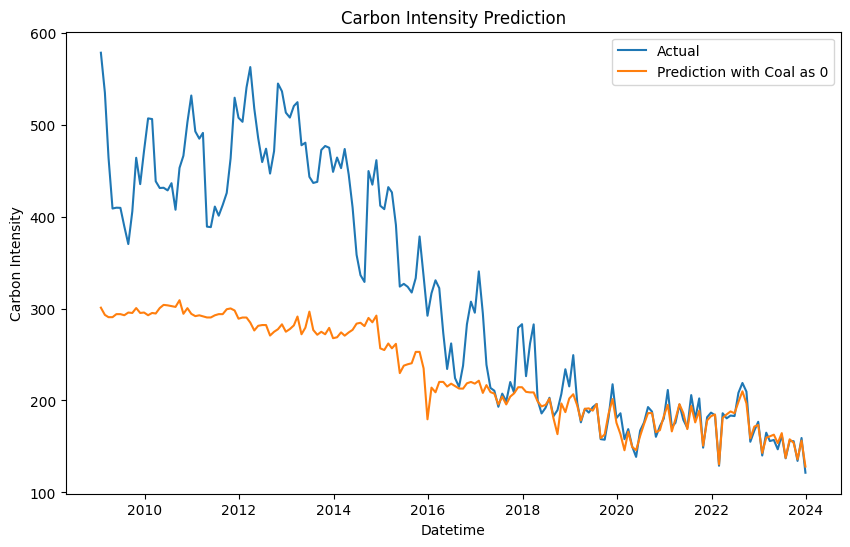

In [ ]:
data_copy_coal = data.copy()
data_copy_coal['COAL'] = 0
# Plot (replace placeholders with actual data and labels)
prediction_coal_decreasedTo0 = model.predict(data_copy_coal.loc[:,top_10_features])

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['CARBON_INTENSITY'], label='Actual')
plt.plot(data.index, prediction_coal_decreasedTo0, label='Prediction with Coal as 0')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Carbon Intensity')
plt.title('Carbon Intensity Prediction')
plt.show()

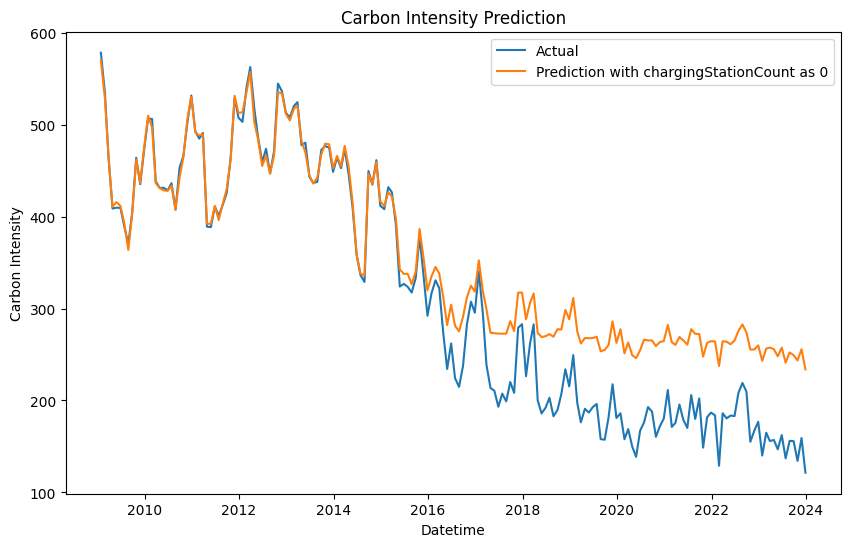

In [ ]:
data_copy_chrgingStationCount = data.copy()
data_copy_chrgingStationCount['chargingStationCount'] = 0
# Plot (replace placeholders with actual data and labels)
prediction_chrgingStationCount_decreasedTo0 = model.predict(data_copy_chrgingStationCount.loc[:,top_10_features])

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['CARBON_INTENSITY'], label='Actual')
plt.plot(data.index, prediction_chrgingStationCount_decreasedTo0, label='Prediction with chargingStationCount as 0')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Carbon Intensity')
plt.title('Carbon Intensity Prediction')
plt.show()

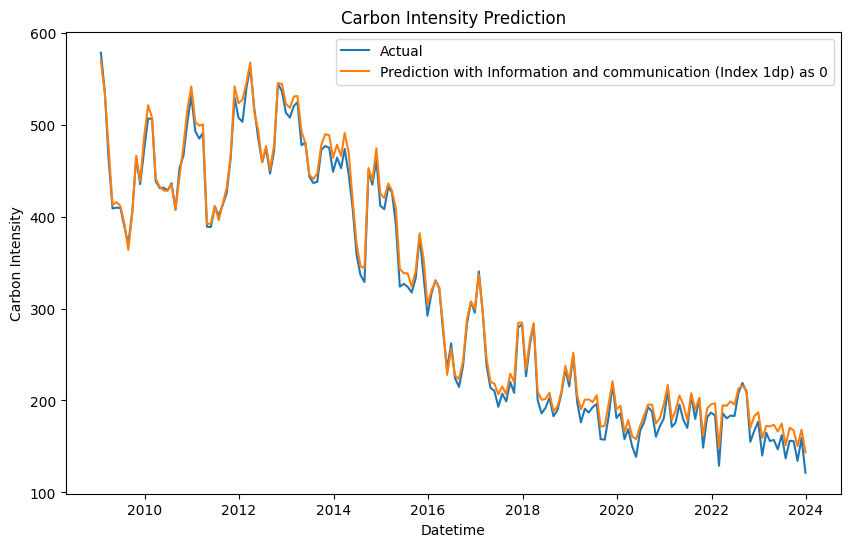

In [ ]:
data_copy_infoCommuni = data.copy()
data_copy_infoCommuni['Information and communication (Index 1dp) :CVM SA'] = 0
# Plot (replace placeholders with actual data and labels)
prediction_infoCommuni_decreasedTo0 = model.predict(data_copy_infoCommuni.loc[:,top_10_features])

plt.figure(figsize=(10, 6))
plt.plot(data.index, data['CARBON_INTENSITY'], label='Actual')
plt.plot(data.index, prediction_infoCommuni_decreasedTo0, label='Prediction with Information and communication (Index 1dp) as 0')
plt.legend()
plt.xlabel('Datetime')
plt.ylabel('Carbon Intensity')
plt.title('Carbon Intensity Prediction')
plt.show()

Forcasting

In [ ]:
# Import necessary libraries
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsm

          Date  Predicted Carbon Intensity
108 2024-01-31                  150.369254
109 2024-02-29                  145.799500
110 2024-03-31                  159.967611
111 2024-04-30                  142.466237
112 2024-05-31                  149.237130
..         ...                         ...
187 2030-08-31                  139.855844
188 2030-09-30                  142.689387
189 2030-10-31                  131.122101
190 2030-11-30                  139.169281
191 2030-12-31                  136.379214

[84 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [ ]:
data=merged_data_new.copy()

In [ ]:
data['DATETIME'] = pd.to_datetime(data[['YEAR', 'MONTH']].assign(DAY=1))

In [ ]:
data['DATETIME'].head()

DATETIME
2009-01-01   2009-01-01
2009-02-01   2009-02-01
2009-03-01   2009-03-01
2009-04-01   2009-04-01
2009-05-01   2009-05-01
Name: DATETIME, dtype: datetime64[ns]

In [ ]:
# Select features and target variable
features = top_10_features
X = data[features]
y = data['CARBON_INTENSITY']

# Scale data
scaler = MinMaxScaler(feature_range=(0,600))
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))  # Reshape y variabl

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0)

# Train the SARIMAX model
model = SARIMAX(y_train, exog=X_train, order=(1, 1, 1), seasonal_order=(1, 1, 1, 12))
sarimax_model = model.fit()

# Create a DataFrame for the future years (2024 to 2030)
future_years = pd.date_range(start='2024-01-01', end='2030-12-31', freq='M')

# Repeat the last row of X_train for the future years
exog_forecast = pd.concat([X_train.iloc[-1:]]*len(future_years))

# Forecast the next 7 years (84 steps)
forecast = sarimax_model.get_forecast(steps=len(future_years), exog=exog_forecast)

# Get the predicted mean values
forecast_mean = forecast.predicted_mean

# Create a DataFrame with the predicted mean values and aligned dates
forecast_df = pd.DataFrame({'Date': future_years, 'Predicted Carbon Intensity': forecast_mean})

# Print the forecasted DataFrame
print(forecast_df)

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


          Date  Predicted Carbon Intensity
108 2024-01-31                  163.447717
109 2024-02-29                  149.148524
110 2024-03-31                  156.466895
111 2024-04-30                  156.165755
112 2024-05-31                  150.080541
..         ...                         ...
187 2030-08-31                  128.890212
188 2030-09-30                  134.570343
189 2030-10-31                  128.645828
190 2030-11-30                  124.205016
191 2030-12-31                  121.280558

[84 rows x 2 columns]


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


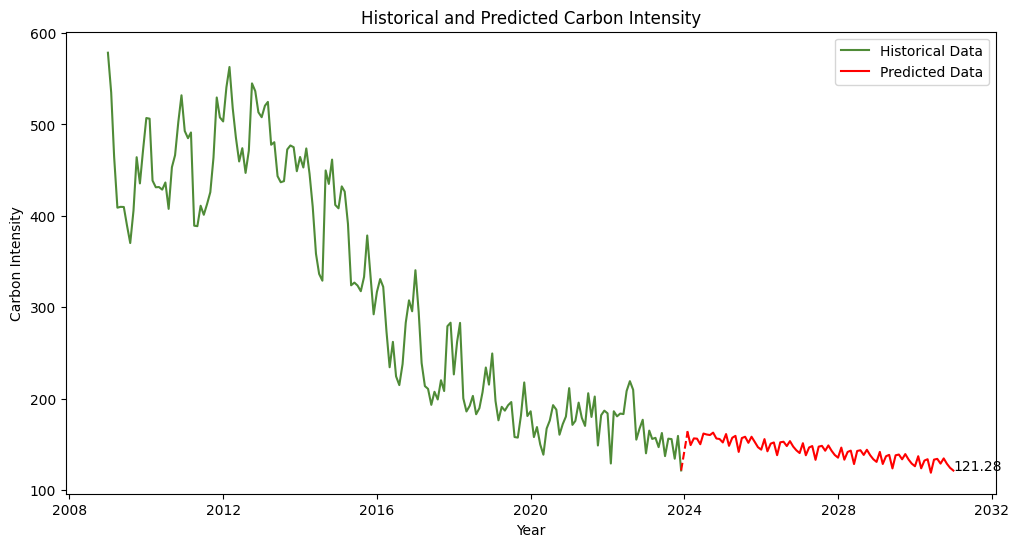

In [ ]:
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(data['DATETIME'], data['CARBON_INTENSITY'], label='Historical Data', color = '#4f8b37')

# Get the last point of the historical data and the first point of the predicted data
last_point_of_historical = data['DATETIME'].values[-1], data['CARBON_INTENSITY'].values[-1]
first_point_of_predicted = forecast_df['Date'].values[0], forecast_df['Predicted Carbon Intensity'].values[0]

# Plot a line between the last point of the historical data and the first point of the predicted data
plt.plot([last_point_of_historical[0], first_point_of_predicted[0]], [last_point_of_historical[1], first_point_of_predicted[1]], color='red', linestyle='--')

# Plot predicted values
plt.plot(forecast_df['Date'], forecast_df['Predicted Carbon Intensity'], label='Predicted Data', color = 'red')

# Annotate the last point of the predicted data
last_point_of_predicted = forecast_df['Date'].values[-1], forecast_df['Predicted Carbon Intensity'].values[-1]
plt.annotate(f'{last_point_of_predicted[1]:.2f}', (last_point_of_predicted[0], last_point_of_predicted[1]))

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Carbon Intensity')
plt.title('Historical and Predicted Carbon Intensity')
plt.legend()

# Show plot
plt.show()


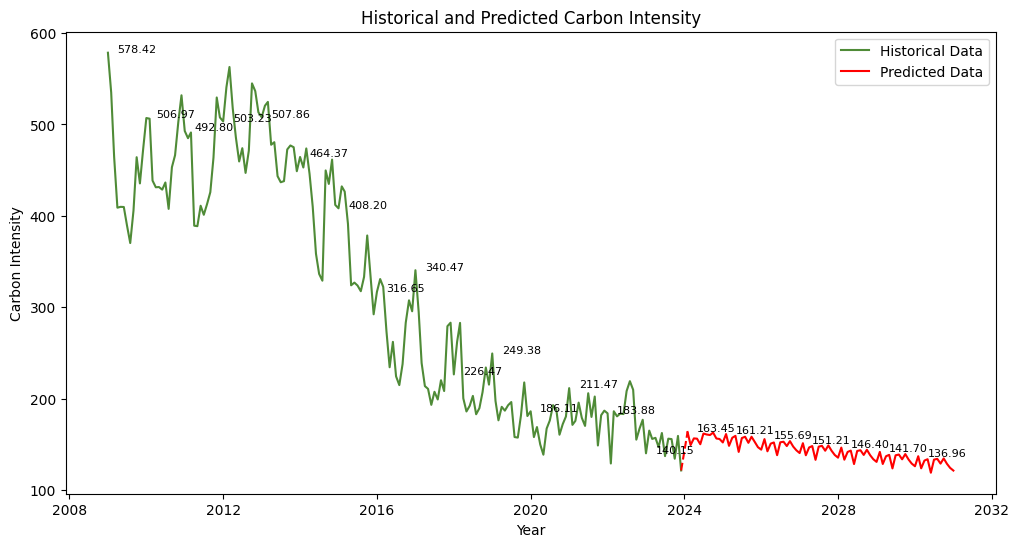

In [ ]:
plt.figure(figsize=(12, 6))

# Plot historical data without markers
plt.plot(data['DATETIME'], data['CARBON_INTENSITY'], label='Historical Data', color = '#4f8b37')

# Annotate each year's value for historical data
for i in range(len(data['DATETIME'])):
    if data['DATETIME'].iloc[i].year != data['DATETIME'].iloc[i-1].year:
        plt.annotate(f'{data["CARBON_INTENSITY"].iloc[i]:.2f}', (data['DATETIME'].iloc[i] + DateOffset(months=3), data['CARBON_INTENSITY'].iloc[i] + 0.3), fontsize=8)

# Get the last point of the historical data and the first point of the predicted data
last_point_of_historical = data['DATETIME'].values[-1], data['CARBON_INTENSITY'].values[-1]
first_point_of_predicted = forecast_df['Date'].values[0], forecast_df['Predicted Carbon Intensity'].values[0]

# Plot a line between the last point of the historical data and the first point of the predicted data
plt.plot([last_point_of_historical[0], first_point_of_predicted[0]], [last_point_of_historical[1], first_point_of_predicted[1]], color='red', linestyle='--')

# Plot predicted values without markers
plt.plot(forecast_df['Date'], forecast_df['Predicted Carbon Intensity'], label='Predicted Data', color = 'red')

# Annotate each year's value for predicted data
for i in range(len(forecast_df['Date'])):
    if forecast_df['Date'].iloc[i].year != forecast_df['Date'].iloc[i-1].year:
        plt.annotate(f'{forecast_df["Predicted Carbon Intensity"].iloc[i]:.2f}', (forecast_df['Date'].iloc[i] + DateOffset(months=3), forecast_df['Predicted Carbon Intensity'].iloc[i] + 0.3), fontsize=8)

# Set labels and title
plt.xlabel('Year')
plt.ylabel('Carbon Intensity')
plt.title('Historical and Predicted Carbon Intensity')
plt.legend()

# Show plot
plt.show()

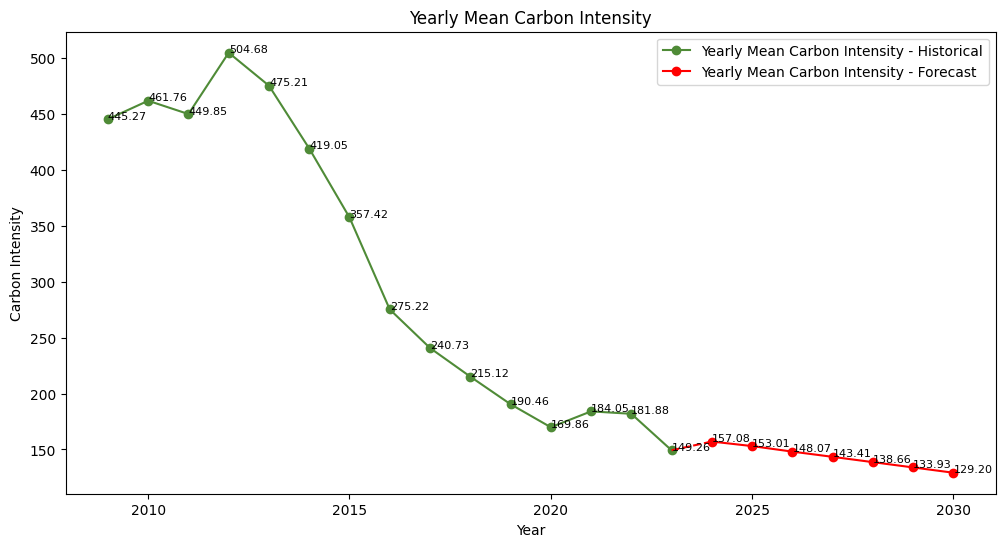

In [ ]:
plt.figure(figsize=(12, 6))

# Plot yearly mean data for historical data with markers
plt.plot(yearly_mean.index, yearly_mean.values, 'o-', label='Yearly Mean Carbon Intensity - Historical', color = '#4f8b37')

# Plot yearly mean data for forecasted data with markers
plt.plot(yearly_mean_forecast.index, yearly_mean_forecast.values, 'o-', label='Yearly Mean Carbon Intensity - Forecast', color = 'red')

# Annotate each year's value for historical data
for i in range(len(yearly_mean)):
    plt.annotate(f'{yearly_mean.iloc[i]:.2f}', (yearly_mean.index[i], yearly_mean.iloc[i]), fontsize=8)

# Annotate each year's value for forecasted data
for i in range(len(yearly_mean_forecast)):
    plt.annotate(f'{yearly_mean_forecast.iloc[i]:.2f}', (yearly_mean_forecast.index[i], yearly_mean_forecast.iloc[i]), fontsize=8)

# Get the last point of the historical data and the first point of the predicted data
last_point_of_historical = yearly_mean.index[-1], yearly_mean.values[-1]
first_point_of_predicted = yearly_mean_forecast.index[0], yearly_mean_forecast.values[0]

# Plot a red dotted line connecting the last point of the historical data and the first point of the predicted data
plt.plot([last_point_of_historical[0], first_point_of_predicted[0]], [last_point_of_historical[1], first_point_of_predicted[1]], 'r--')

plt.xlabel('Year')
plt.ylabel('Carbon Intensity')
plt.title('Yearly Mean Carbon Intensity')
plt.legend()

plt.show()
